In [1]:
import re
import math
import torch
import metrics
import ruptures
import ordpy as op
import numpy as np
import pandas as pd
import ruptures as rpt
# from klcpd import KL_CPD
import scipy.stats as st
import colorednoise as cn
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
# from xgboost import XGBClassifier
from collections import OrderedDict
from LSTM.models import binary_model
from catboost import CatBoostClassifier
from IPython.display import clear_output
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from ruptures.metrics import randindex, precision_recall
from data_generation2 import Binary_Telegraph_Process as BTP
from sklearn.model_selection import train_test_split as tts
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import balanced_accuracy_score, f1_score, auc, precision_recall_curve

import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# os.environ['KMP_DUPLICATE_LIB_OK']='True'
# from xgboost import XGBClassifier

In [19]:
class synth_cpd_pipeline(object):
    def __init__(self, method='log-return', sample_len=10000, n_epochs=100, save_results=False):

        self.data   = {r'Белый, $\alpha = 1$':[], r'Белый, $\alpha = 2$':[], r'Белый, $\alpha = \pi$':[],
                       r'Розовый, $\alpha = 1$':[], r'Розовый, $\alpha = 2$':[], r'Розовый, $\alpha = \pi$':[],
                       r'Красный, $\alpha = 1$':[], r'Красный, $\alpha = 2$':[], r'Красный, $\alpha = \pi$':[],
                       r'Синий, $\alpha = 1$':[], r'Синий, $\alpha = 2$':[], r'Синий, $\alpha = \pi$':[],
                       r'Фиолетовый, $\alpha = 1$':[], r'Фиолетовый, $\alpha = 2$':[], r'Фиолетовый, $\alpha = \pi$':[],
                       r'el_nino, $\alpha = 1$':[], r'el_nino, $\alpha = 2$':[], r'el_nino, $\alpha = \pi$':[]}
        self.labels = []
        self.lr     = []
        self.noise  = [r'Белый, $\alpha = 1$', r'Розовый, $\alpha = 1$', r'Красный, $\alpha = 1$', r'Синий, $\alpha = 1$', r'Фиолетовый, $\alpha = 1$', r'el_nino, $\alpha = 1$',
                       r'Белый, $\alpha = 2$', r'Розовый, $\alpha = 2$', r'Красный, $\alpha = 2$', r'Синий, $\alpha = 2$', r'Фиолетовый, $\alpha = 2$', r'el_nino, $\alpha = 2$',
                       r'Белый, $\alpha = \pi$', r'Розовый, $\alpha = \pi$', r'Красный, $\alpha = \pi$', r'Синий, $\alpha = \pi$', r'Фиолетовый, $\alpha = \pi$', r'el_nino, $\alpha = \pi$']
        self.method = method
        self.sample_len = sample_len
        self.random_seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] # el_nino
        self.horizon = [1, 2, 5, 10, 25]#, 10, 100]
        self.n_epochs = n_epochs
        self.save_results = save_results


    def init_data(self):

        for seed in self.random_seeds:
            # Normal
            self.data[r'Белый, $\alpha = 1$'].append(BTP(self.sample_len, np.random.normal, 0, 1, RANDOM_SEED=seed))
            self.data[r'Белый, $\alpha = 2$'].append(BTP(self.sample_len, np.random.normal, 0, 2, RANDOM_SEED=seed))
            self.data[r'Белый, $\alpha = \pi$'].append(BTP(self.sample_len, np.random.normal, 0, math.pi, RANDOM_SEED=seed))
            # Pink
            self.data[r'Розовый, $\alpha = 1$'].append(BTP(self.sample_len, cn.powerlaw_psd_gaussian, 1, RANDOM_SEED=seed, alpha=1))
            self.data[r'Розовый, $\alpha = 2$'].append(BTP(self.sample_len, cn.powerlaw_psd_gaussian, 1, RANDOM_SEED=seed, alpha=2))
            self.data[r'Розовый, $\alpha = \pi$'].append(BTP(self.sample_len, cn.powerlaw_psd_gaussian, 1, RANDOM_SEED=seed, alpha=math.pi))
            # Red
            self.data[r'Красный, $\alpha = 1$'].append(BTP(self.sample_len, cn.powerlaw_psd_gaussian, 2, RANDOM_SEED=seed, alpha=1))
            self.data[r'Красный, $\alpha = 2$'].append(BTP(self.sample_len, cn.powerlaw_psd_gaussian, 2, RANDOM_SEED=seed, alpha=2))
            self.data[r'Красный, $\alpha = \pi$'].append(BTP(self.sample_len, cn.powerlaw_psd_gaussian, 2, RANDOM_SEED=seed, alpha=math.pi))
            # Blue
            self.data[r'Синий, $\alpha = 1$'].append(BTP(self.sample_len, cn.powerlaw_psd_gaussian, -1, RANDOM_SEED=seed, alpha=1))
            self.data[r'Синий, $\alpha = 2$'].append(BTP(self.sample_len, cn.powerlaw_psd_gaussian, -1, RANDOM_SEED=seed, alpha=2))
            self.data[r'Синий, $\alpha = \pi$'].append(BTP(self.sample_len, cn.powerlaw_psd_gaussian, -1, RANDOM_SEED=seed, alpha=math.pi))
            # Violet
            self.data[r'Фиолетовый, $\alpha = 1$'].append(BTP(self.sample_len, cn.powerlaw_psd_gaussian, -2, RANDOM_SEED=seed, alpha=1))
            self.data[r'Фиолетовый, $\alpha = 2$'].append(BTP(self.sample_len, cn.powerlaw_psd_gaussian, -2, RANDOM_SEED=seed, alpha=2))
            self.data[r'Фиолетовый, $\alpha = \pi$'].append(BTP(self.sample_len, cn.powerlaw_psd_gaussian, -2, RANDOM_SEED=seed, alpha=math.pi))
            # el_nino
            self.data[r'el_nino, $\alpha = 1$'].append(BTP(self.sample_len, p1 = 'el_nino', RANDOM_SEED=seed))
            self.data[r'el_nino, $\alpha = 2$'].append(BTP(self.sample_len, p1 = 'el_nino', RANDOM_SEED=seed))
            self.data[r'el_nino, $\alpha = \pi$'].append(BTP(self.sample_len, p1 = 'el_nino', RANDOM_SEED=seed))

    def autoregression_matrix(self, X, periods=1, fill_value=0):
        shifted_x = [pd.DataFrame(X).shift(periods=i, fill_value=fill_value).values for i in range(periods)]
        return np.hstack(tuple(shifted_x))

    def single_cpd_predict(self, noise):

        qms = []
        f1, acc, pr = dict.fromkeys(self.horizon), dict.fromkeys(self.horizon), dict.fromkeys(self.horizon)

        for btp in tqdm(self.data[noise], desc=noise):

            X = np.array(btp.get_data())
            L = btp.labels()#['levels'].values
            y = np.array(btp.labels_)
            # y[y > 0] = 1

            if self.method == 'lstm':
                lstm = binary_model(X.astype(np.float32), 0.7, 10, model='lstm', n_epochs=self.n_epochs)
                lstm.model_fit(verbose=0)

            single_qms = []

            for h in self.horizon:

                X_auto = self.autoregression_matrix(X, periods=h)

                mask = np.isfinite(X_auto).all(axis=1) & np.isfinite(y)
                X_auto = X_auto[mask]
                y = y[mask]

                X_train, X_test, y_train, y_test = tts(X_auto, y, test_size=0.5, shuffle=True, stratify=y)

                if self.method == 'LDA':

                    mdl = LinearDiscriminantAnalysis()
                    mdl.fit(X_train, y_train)
                    y_pred = mdl.predict(X_test)
                    y_true = y_test
                    
                if self.method == 'QDA':

                    mdl = QuadraticDiscriminantAnalysis()
                    mdl.fit(X_train, y_train)
                    y_pred = mdl.predict(X_test)
                    y_true = y_test

                elif self.method == 'MLP':

                    mdl = MLPClassifier()
                    mdl.fit(X_train, y_train)
                    y_pred = mdl.predict(X_test)
                    y_true = y_test
                    
                if self.method == 'Binseg':
            
                    y1 = y[mask]
                    signal = X_auto
                    if signal.ndim == 1:
                        signal = signal.reshape(-1, 1)

                    algo = rpt.Binseg(model='l2').fit(signal)
                    predicted_bkps = algo.predict(pen=3)

                    # вручную строим бинарный вектор
                    y_pred = np.zeros_like(y1)
                    y_pred[predicted_bkps[:-1]] = 1

                    y_true = np.zeros_like(y1)
                    y_true[np.where(np.diff(y1) != 0)[0]] = 1
    
                if self.method == 'Window':
            
                    y1 = y[mask]
                    signal = X_auto
                    if signal.ndim == 1:
                        signal = signal.reshape(-1, 1)

                    algo = rpt.Window(model='l2').fit(signal)
                    predicted_bkps = algo.predict(pen=3)

                    # вручную строим бинарный вектор
                    y_pred = np.zeros_like(y1)
                    y_pred[predicted_bkps[:-1]] = 1

                    y_true = np.zeros_like(y1)
                    y_true[np.where(np.diff(y1) != 0)[0]] = 1                  
    
                elif self.method == 'Pelt':
            
                    y1 = y[mask]
                    signal = X_auto
                    if signal.ndim == 1:
                        signal = signal.reshape(-1, 1)

                    # change point detection
                    model = "l1"  # "l2", "rbf"
                    algo = rpt.Pelt(model=model, min_size=3, jump=5).fit(signal)
                    my_bkps = algo.predict(pen=3)
                    
                    # вручную строим бинарный вектор
                    y_pred = np.zeros_like(y1)
                    y_pred[my_bkps[:-1]] = 1

                    y_true = np.zeros_like(y1)
                    y_true[np.where(np.diff(y1) != 0)[0]] = 1
                                    

                f1_ = f1_score(y_true, y_pred, average='weighted', labels=np.unique(y_pred))
                acc_ = balanced_accuracy_score(y_true, y_pred)
                precision, recall, thr = precision_recall_curve(y_true, y_pred)
                pr_ = auc(recall, precision)

                single_qms.append([f1_, acc_, pr_])

            qms.append(single_qms)

        mu = np.mean(qms, axis=0)
        er = np.std(qms, axis=0) / np.sqrt(len(qms))

        print(mu)

        for h_i, h in enumerate(self.horizon):
            f1[h] = "%.3f ± %.3f" % (mu[h_i][0], er[h_i][0])
            acc[h] = "%.3f ± %.3f" % (mu[h_i][1], er[h_i][1])
            pr[h] = "%.3f ± %.3f" % (mu[h_i][2], er[h_i][2])

        return f1, acc, pr

    def cpd_predict(self):
        f1, acc, pr = dict.fromkeys(self.noise), dict.fromkeys(self.noise), dict.fromkeys(self.noise)

        if len(self.lr) == 0:
            self.init_data()

        for noise in tqdm(self.data.keys(), leave=True, position=0):
            if (self.method == 'LDA') and (noise == r'Синий, $\alpha = 1$' or noise == r'Фиолетовый, $\alpha = 1$'):
                continue
            if (self.method == 'QDA') and (noise == r'Синий, $\alpha = 1$' or noise == r'Фиолетовый, $\alpha = 1$'):
                continue
            if (self.method == 'MLP') and (noise == r'Синий, $\alpha = 1$' or noise == r'Фиолетовый, $\alpha = 1$'):
                continue
            if (self.method == 'Binseg') and (noise == r'Синий, $\alpha = 1$' or noise == r'Фиолетовый, $\alpha = 1$'):
                continue
            if (self.method == 'Pelt') and (noise == r'Синий, $\alpha = 1$' or noise == r'Фиолетовый, $\alpha = 1$'):
                continue 
            if (self.method == 'Window') and (noise == r'Синий, $\alpha = 1$' or noise == r'Фиолетовый, $\alpha = 1$'):
                continue                 
            f1[noise], acc[noise], pr[noise] = self.single_cpd_predict(noise)

        f1, acc, pr = pd.DataFrame(f1).T, pd.DataFrame(acc).T, pd.DataFrame(pr).T

        if self.save_results:
            f1.sort_index(inplace=True)
            acc.sort_index(inplace=True)
            pr.sort_index(inplace=True)

            f1.to_csv(f'{self.method}_f1.csv')
            acc.to_csv(f'{self.method}_acc.csv')
            pr.to_csv(f'{self.method}_pr.csv')

        self.f1 = f1
        self.acc = acc
        self.pr = pr

    def plot_delta_t(self, n_bins=20):

        self.init_data()

        fig, ax = plt.subplots(ncols=6, nrows=3, figsize=(20, 10))

        c = 0

        for i, noise in enumerate(self.noise):

            labels = np.array([])
            for btp in self.data[noise]:
                X = np.array(btp.get_data())
                L = btp.labels()
                y = np.array(btp.labels_)
                label = np.arange(len(y))[y > 0]
                labels = np.concatenate((labels, np.abs(label[1:]-label[:-1])))

            labels = np.array(labels).squeeze()

            # print(noise, )
            c += len(labels)/10_000

            ax[i//6, i%6].set_yscale('log')
            ax[i//6, i%6].hist(labels, n_bins)
            if i%6 == 0:
                ax[i//6, i%6].set_ylabel('Частота', fontsize=16, weight='bold')
            if i//6 == 2:
                ax[i//6, i%6].set_xlabel(r'$\Delta$ t', fontsize=16, weight='bold')
            ax[i//6, i%6].set_title(noise, fontsize=16)
            ax[i//6, i%6].tick_params(labelsize=16)

        # print(c / 15)

        fig.suptitle('Частоты расстоянии между точками разладки', fontsize=20, weight='bold')
        plt.tight_layout()
        plt.show()

        fig.savefig('histogram_changes_synth.jpeg', format='jpeg', dpi=200)

In [20]:
def results_to_csv(pipeline_obj, filename="cpd_results.csv"):
    results = []
    horizons = pipeline_obj.horizon
    model_name = pipeline_obj.method

    for noise in pipeline_obj.noise:
        match = re.match(r"(\w+), \$\\alpha = ([^$]+)\$", noise)
        if match:
            noise_type, alpha = match.groups()

            for h in horizons:
                row = {
                    'noise_type': noise_type,
                    'alpha': alpha,
                    'model': model_name,
                    'horizon': h,
                    'f1': pipeline_obj.f1.loc[noise][h],
                    'acc': pipeline_obj.acc.loc[noise][h],
                    'pr': pipeline_obj.pr.loc[noise][h]
                }
                results.append(row)

    df = pd.DataFrame(results)

    df_long = df.melt(
        id_vars=['noise_type', 'alpha', 'model', 'horizon'],
        value_vars=['f1', 'acc', 'pr'],
        var_name='metric_name',
        value_name='metric_value'
    )

    df_long.to_csv(filename, index=False)
    return df_long

In [21]:
def CPD(method):

    cpd = synth_cpd_pipeline(method = method, save_results=True)
    cpd.plot_delta_t()

    return cpd

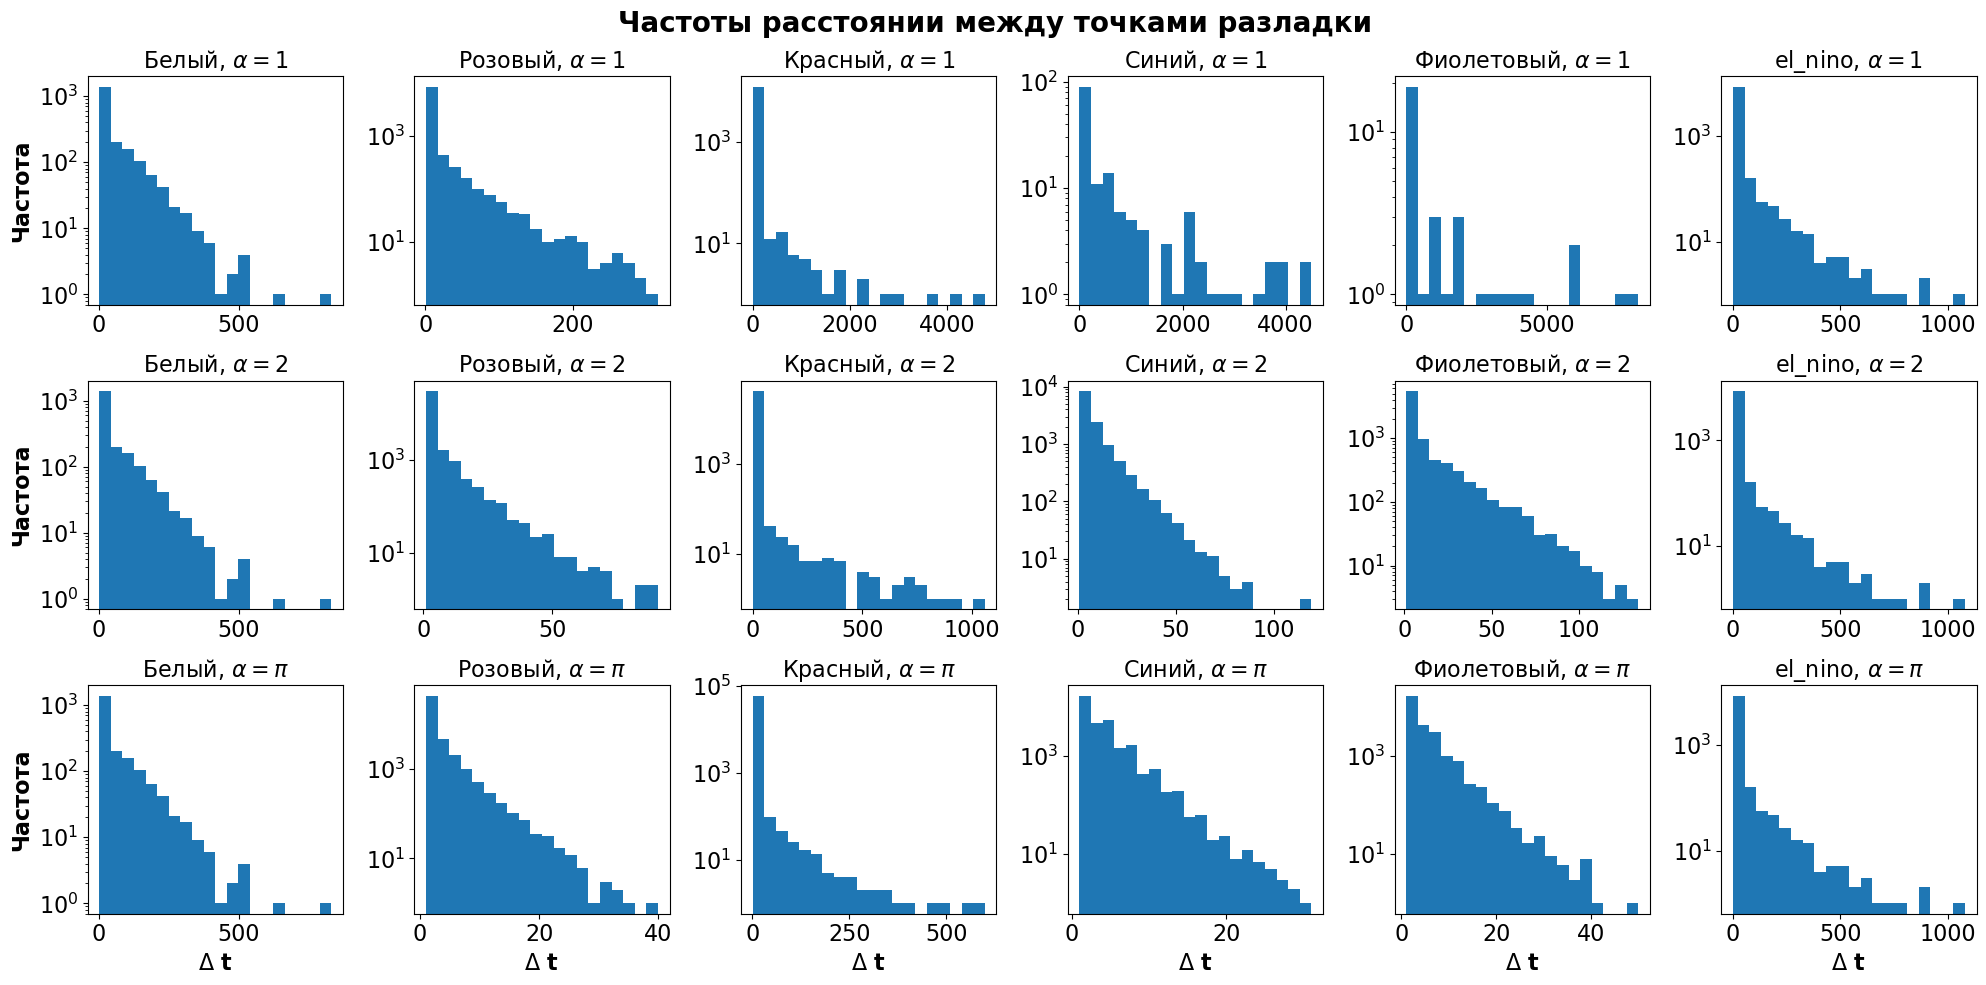

In [22]:
cpd_lda= CPD(method = "LDA")

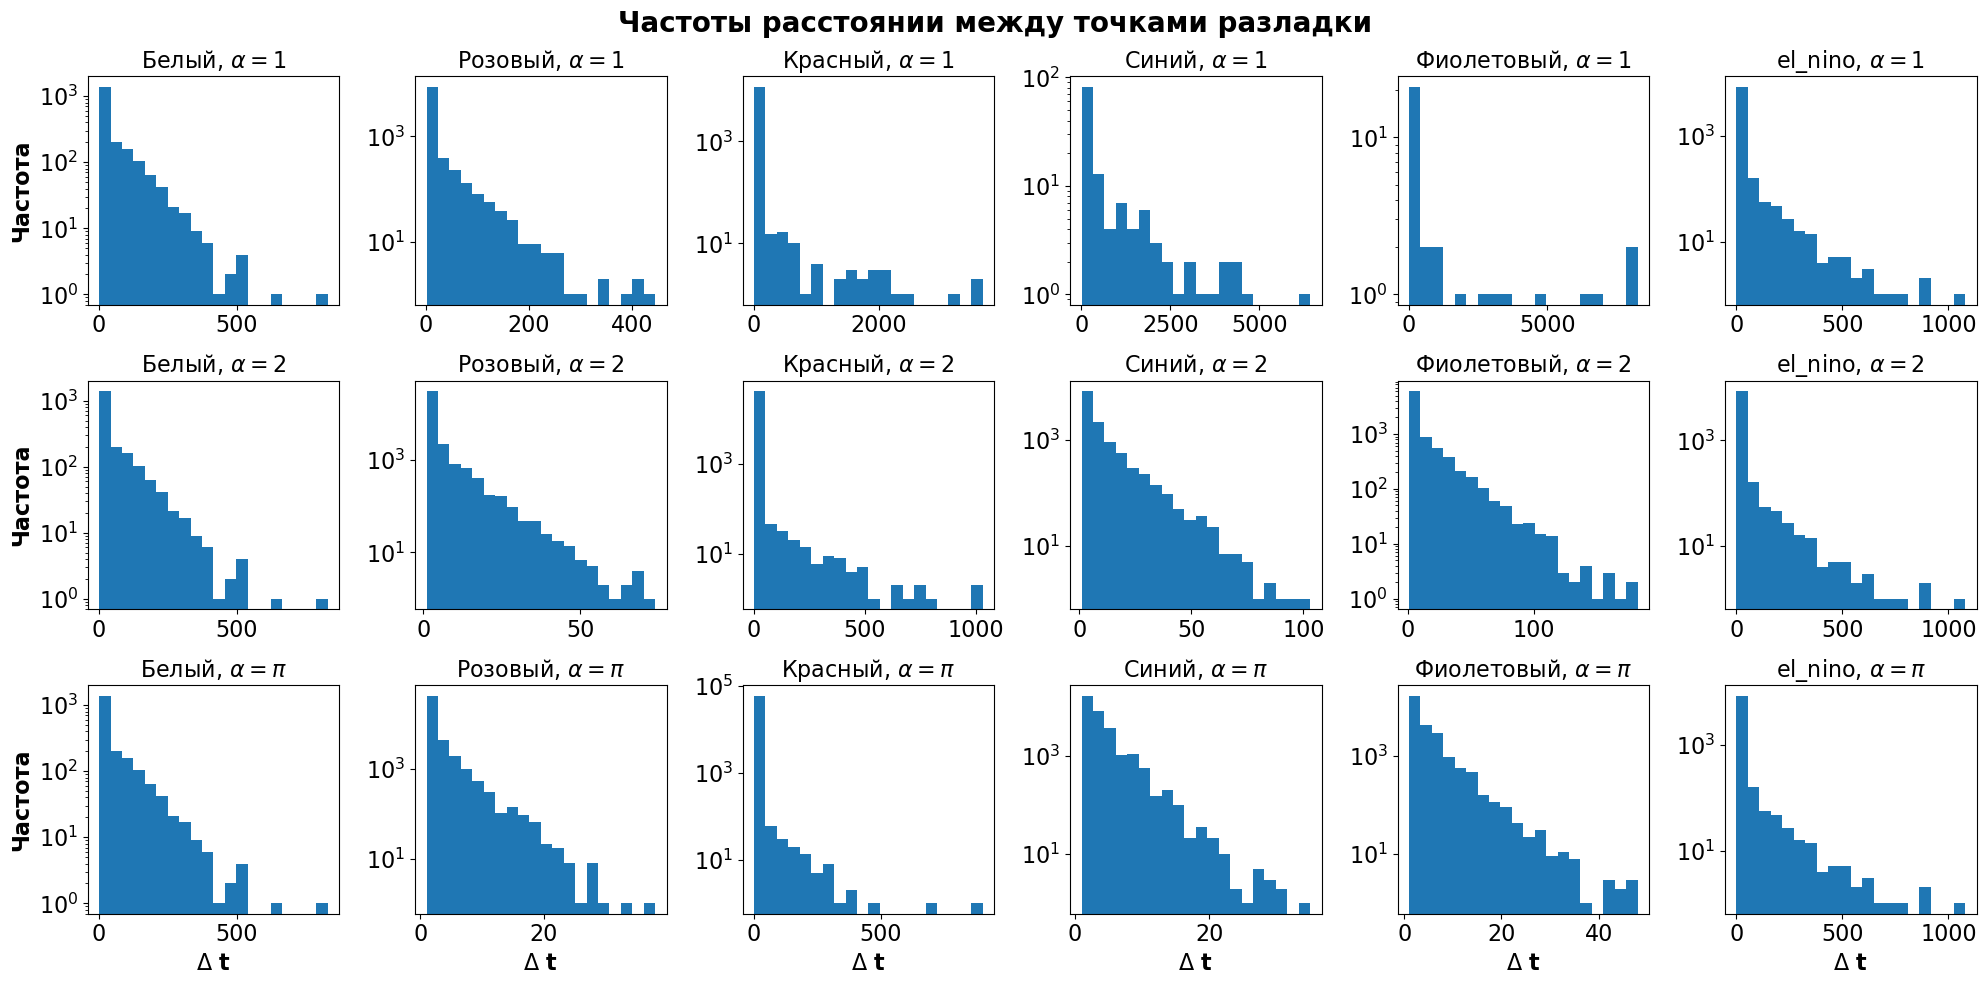

In [23]:
cpd_qda= CPD(method = "QDA")

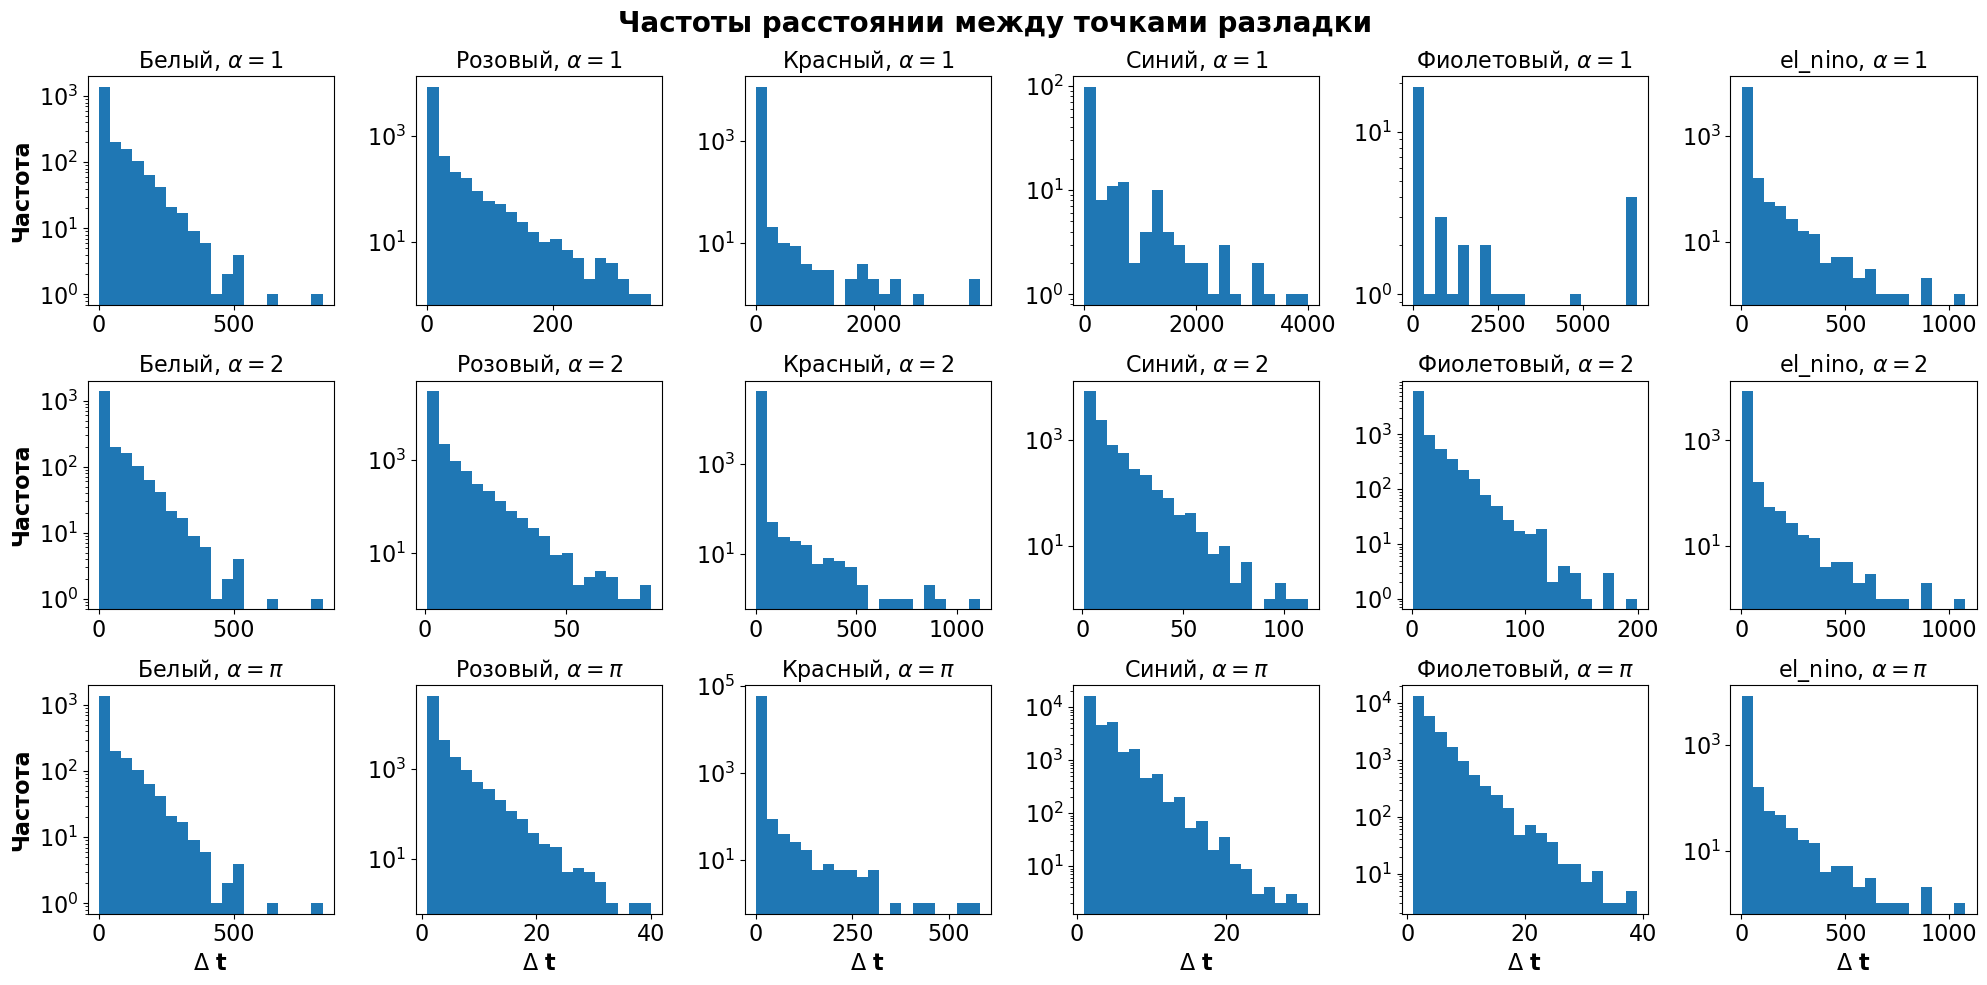

In [24]:
cpd_mlp= CPD(method = "MLP")

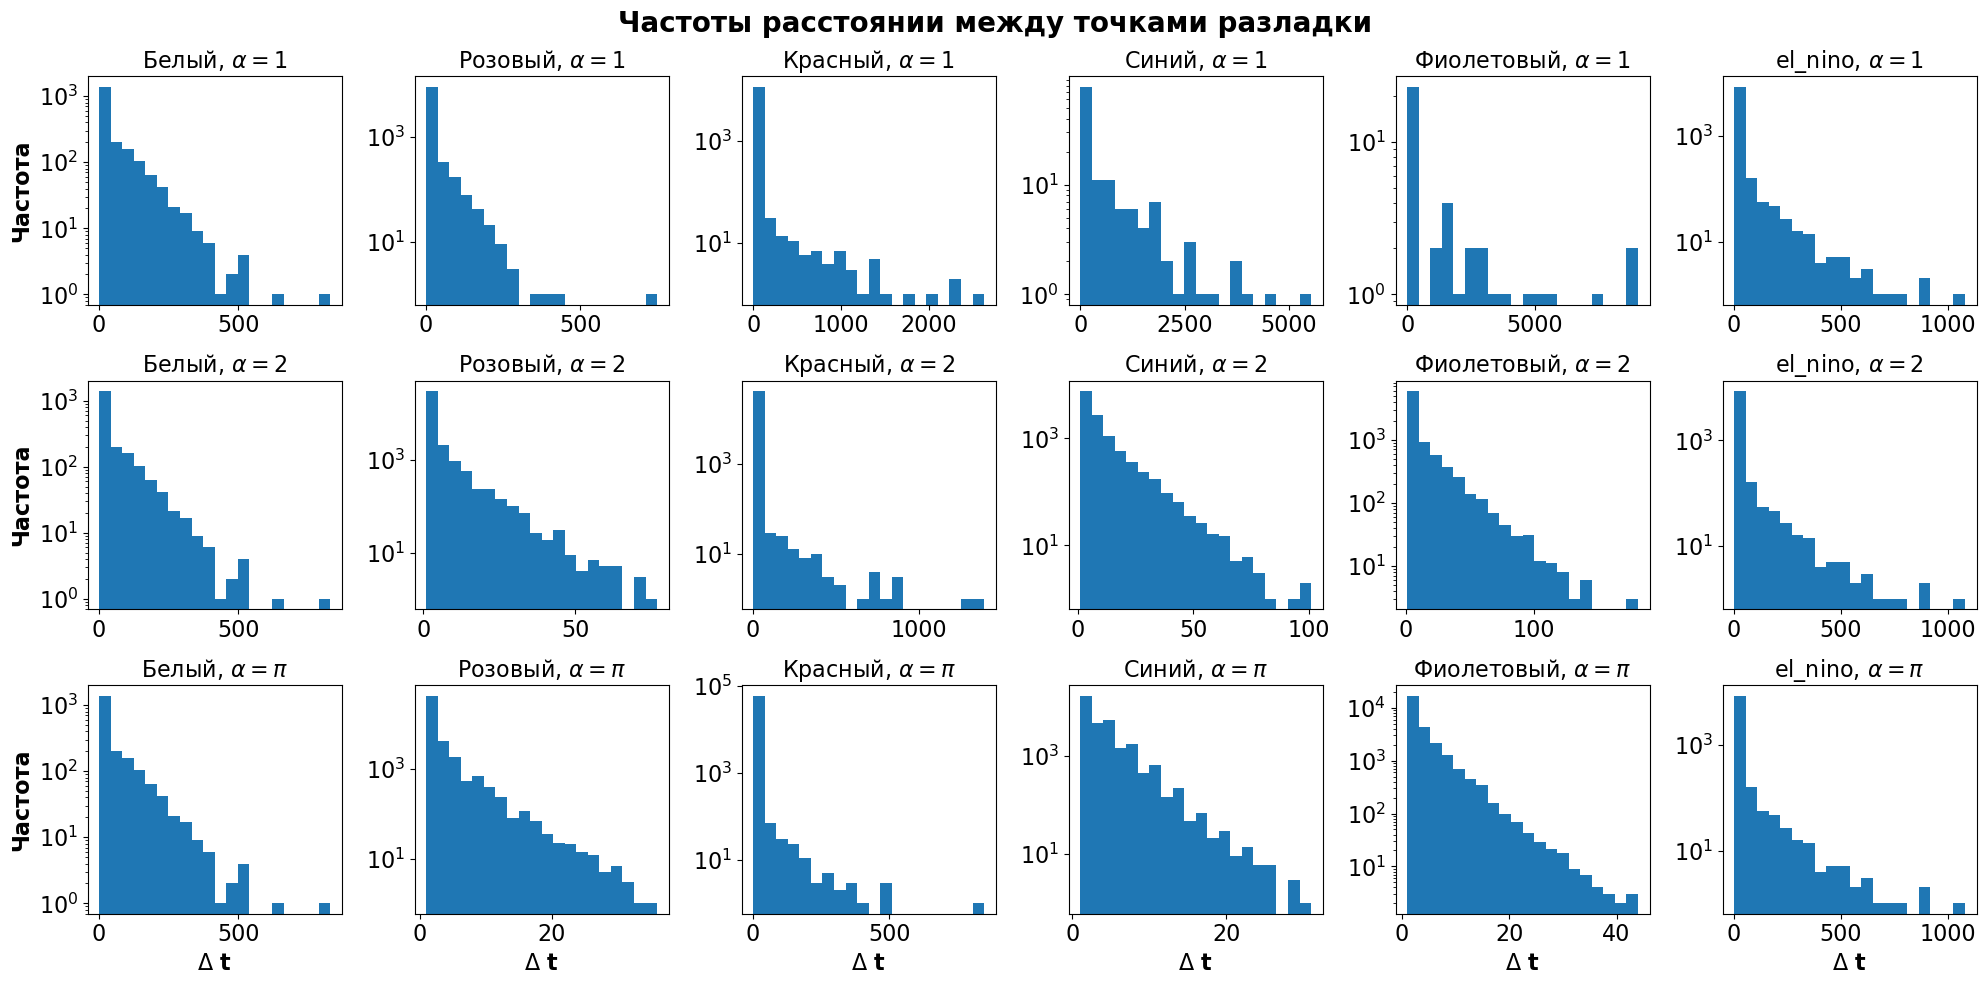

In [25]:
cpd_bns= CPD(method = "Binseg")

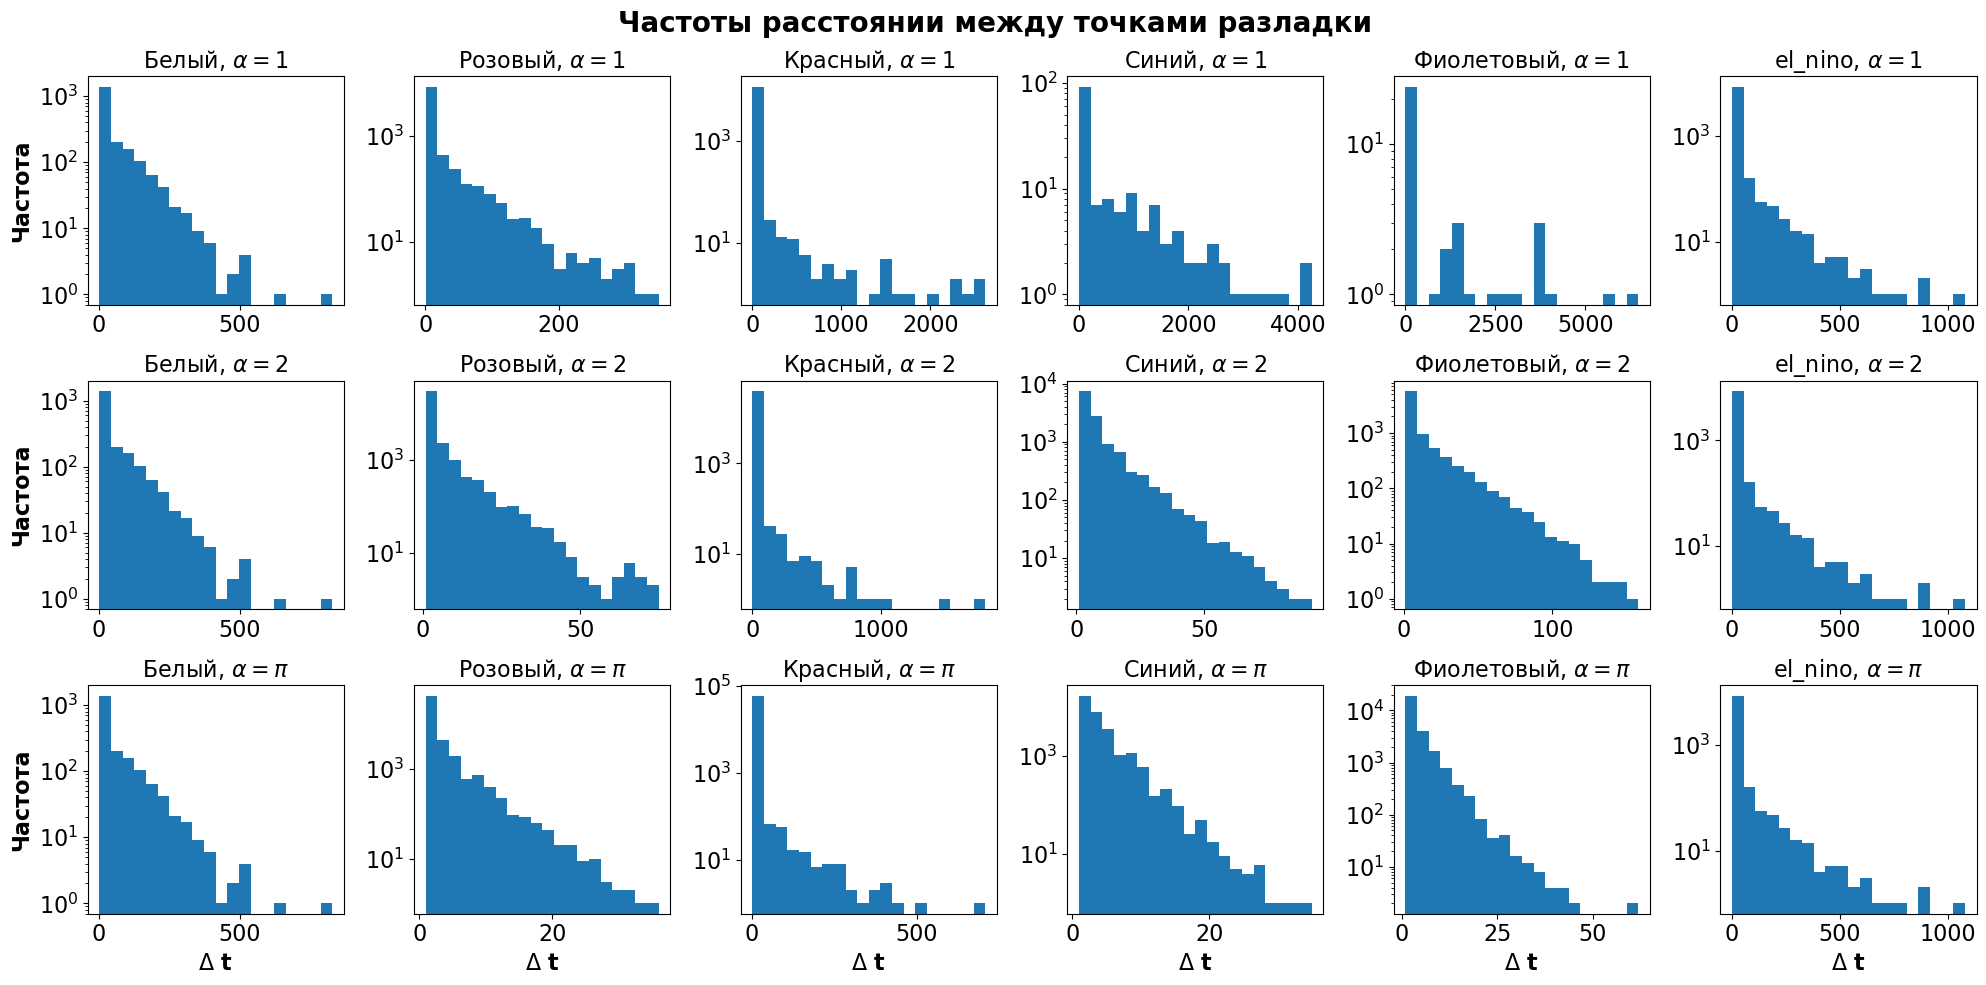

In [26]:
cpd_wnd= CPD(method = "Window")

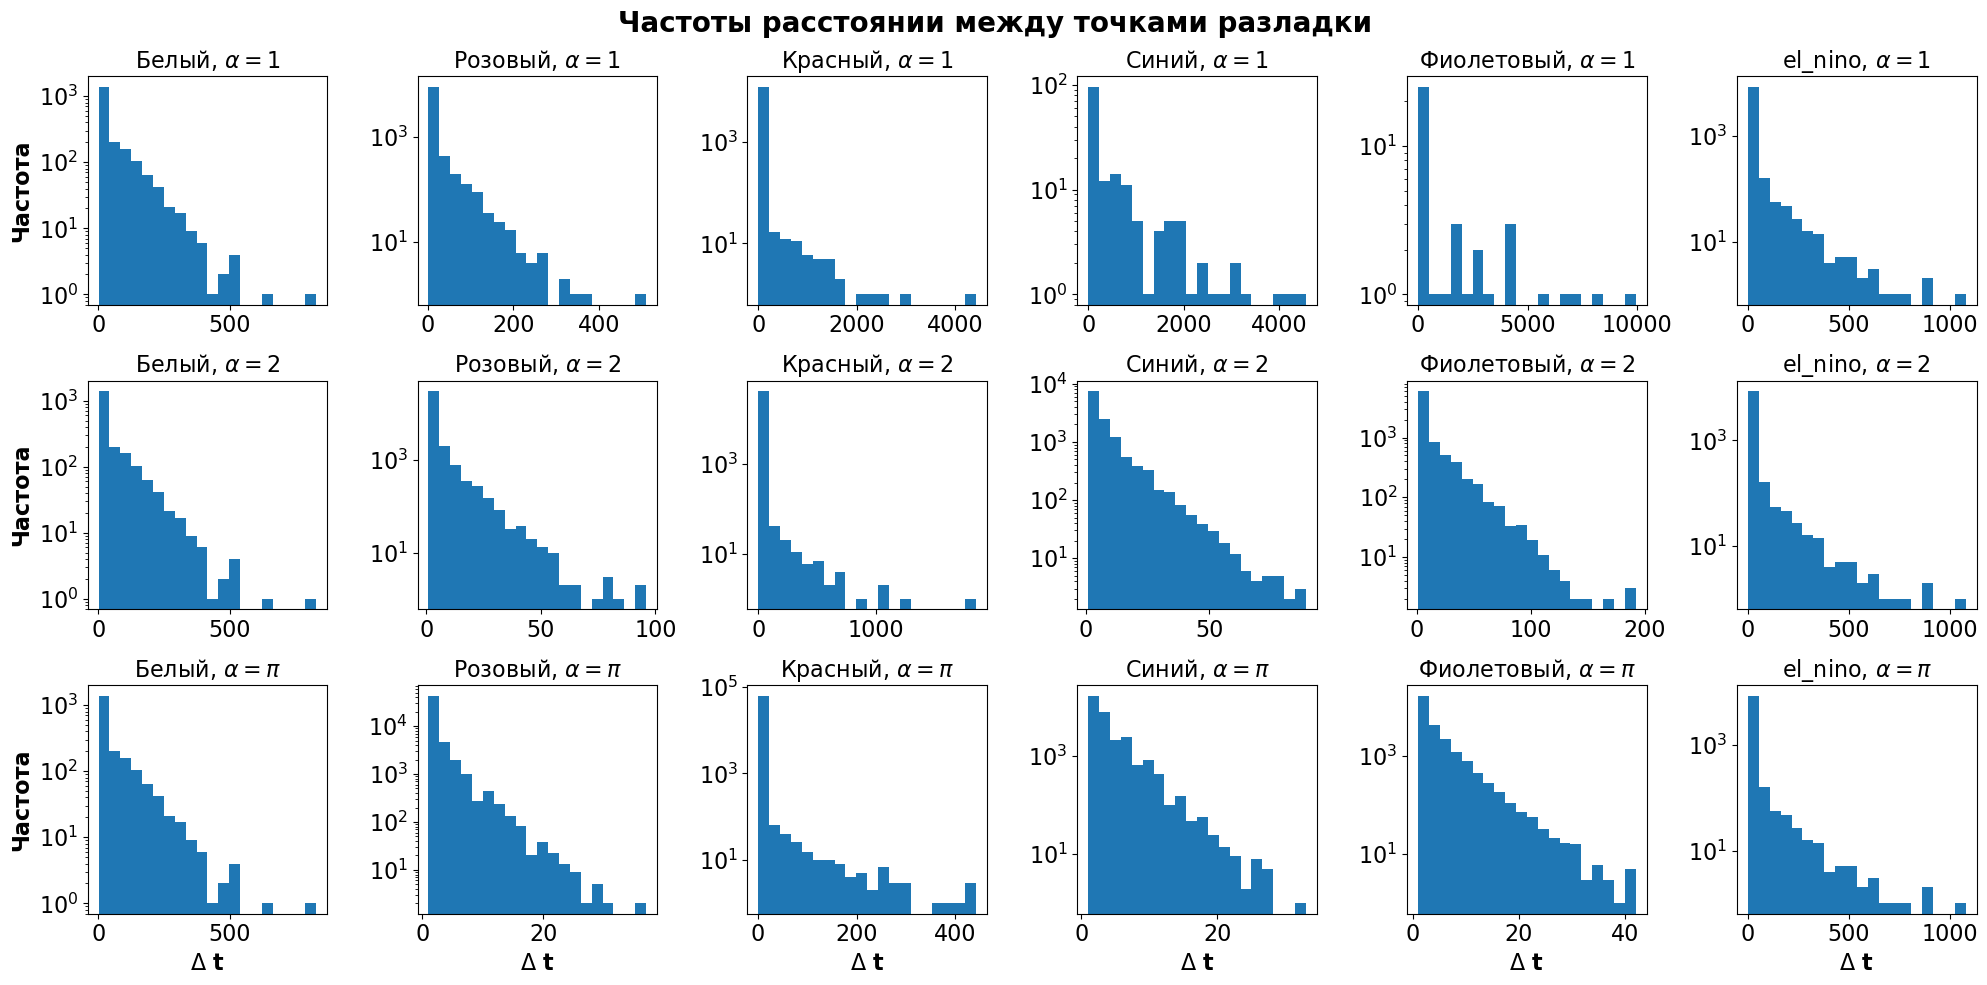

In [27]:
cpd_plt= CPD(method = "Pelt")

In [28]:
f1, acc, pr = cpd_lda.cpd_predict()

  0%|          | 0/18 [00:00<?, ?it/s]

Белый, $\alpha = 1$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.98969614 0.5        0.51019796]
 [0.98969614 0.5        0.51019796]
 [0.98969614 0.5        0.51019796]
 [0.98969614 0.5        0.51019796]
 [0.98782436 0.49998981 0.46019796]]


Белый, $\alpha = 2$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.98969614 0.5        0.51019796]
 [0.98969614 0.5        0.51019796]
 [0.98969614 0.5        0.51019796]
 [0.98969614 0.5        0.51019796]
 [0.98782436 0.49998981 0.46019796]]


Белый, $\alpha = \pi$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.98969614 0.5        0.51019796]
 [0.98969614 0.5        0.51019796]
 [0.98969614 0.5        0.51019796]
 [0.98969614 0.5        0.51019796]
 [0.98782436 0.49998981 0.46019796]]


Розовый, $\alpha = 1$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.94800829 0.5        0.54942012]
 [0.94800829 0.5        0.54942012]
 [0.94800829 0.5        0.54942012]
 [0.94327004 0.5000497  0.54946482]
 [0.92974331 0.5010898  0.52399681]]


Розовый, $\alpha = 2$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.79307345 0.5        0.67144071]
 [0.78072662 0.50071816 0.67142147]
 [0.76880972 0.50178424 0.6620935 ]
 [0.74131907 0.50108133 0.62207646]
 [0.62418964 0.50432167 0.55559671]]


Розовый, $\alpha = \pi$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.55623107 0.51159091 0.72962487]
 [0.48774824 0.49875302 0.72685879]
 [0.44960117 0.50505766 0.72089335]
 [0.484058   0.51054941 0.70658993]
 [0.5003445  0.51141014 0.69231439]]


Красный, $\alpha = 1$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.9325472  0.50173148 0.55257035]
 [0.90493047 0.54276966 0.56409984]
 [0.90093402 0.56072923 0.53007995]
 [0.89060678 0.56430005 0.51887331]
 [0.86534297 0.56979639 0.49192302]]


Красный, $\alpha = 2$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.62295226 0.52842451 0.6048209 ]
 [0.6233104  0.58331396 0.65262679]
 [0.60455488 0.59016244 0.63593196]
 [0.60338088 0.58856623 0.62642725]
 [0.61235281 0.59565373 0.63280073]]


Красный, $\alpha = \pi$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.71614027 0.55638482 0.80548829]
 [0.70938508 0.54864111 0.80103835]
 [0.60749853 0.54619726 0.79888496]
 [0.57291559 0.54362462 0.79718145]
 [0.57630453 0.5403732  0.79400783]]


Синий, $\alpha = 2$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.93111087 0.5        0.56444711]
 [0.93111087 0.5        0.56444711]
 [0.93111087 0.5        0.56444711]
 [0.93111087 0.5        0.56444711]
 [0.93111087 0.5        0.56444711]]


Синий, $\alpha = \pi$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.81528588 0.5        0.65590882]
 [0.81528588 0.5        0.65590882]
 [0.81528588 0.5        0.65590882]
 [0.81528588 0.5        0.65590882]
 [0.81528588 0.5        0.65590882]]


Фиолетовый, $\alpha = 2$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.95515224 0.5        0.54292142]
 [0.95515224 0.5        0.54292142]
 [0.95515224 0.5        0.54292142]
 [0.95515224 0.5        0.54292142]
 [0.95515224 0.5        0.54292142]]


Фиолетовый, $\alpha = \pi$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.84643523 0.5        0.63311838]
 [0.84643523 0.5        0.63311838]
 [0.84643523 0.5        0.63311838]
 [0.84643523 0.5        0.63311838]
 [0.84643523 0.5        0.63311838]]


el_nino, $\alpha = 1$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.95312536 0.5        0.54461108]
 [0.91327806 0.57351543 0.55979254]
 [0.91086216 0.61507341 0.57247003]
 [0.90072749 0.6106187  0.54914912]
 [0.90243402 0.6185625  0.47415763]]


el_nino, $\alpha = 2$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.95312536 0.5        0.54461108]
 [0.91327806 0.57351543 0.55979254]
 [0.91086216 0.61507341 0.57247003]
 [0.90072749 0.6106187  0.54914912]
 [0.90243402 0.6185625  0.47415763]]


el_nino, $\alpha = \pi$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.95312536 0.5        0.54461108]
 [0.91327806 0.57351543 0.55979254]
 [0.91086216 0.61507341 0.57247003]
 [0.90072749 0.6106187  0.54914912]
 [0.90243402 0.6185625  0.47415763]]


TypeError: cannot unpack non-iterable NoneType object

In [29]:
f1, acc, pr = cpd_qda.cpd_predict()

  0%|          | 0/18 [00:00<?, ?it/s]

Белый, $\alpha = 1$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.98969614 0.5        0.51019796]
 [0.98351259 0.50230555 0.48747398]
 [0.97246836 0.54305153 0.29391975]
 [0.97363702 0.63862751 0.33512532]
 [0.9718081  0.57669722 0.24799671]]


Белый, $\alpha = 2$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.98969614 0.5        0.51019796]
 [0.98351259 0.50230555 0.48747398]
 [0.97246836 0.54305153 0.29391975]
 [0.97363702 0.63862751 0.33512532]
 [0.9718081  0.57669722 0.24799671]]


Белый, $\alpha = \pi$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.98969614 0.5        0.51019796]
 [0.98351259 0.50230555 0.48747398]
 [0.97246836 0.54305153 0.29391975]
 [0.97363702 0.63862751 0.33512532]
 [0.9718081  0.57669722 0.24799671]]


Розовый, $\alpha = 1$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.94810639 0.5        0.54933013]
 [0.91784583 0.70113913 0.5993983 ]
 [0.92934968 0.75940458 0.65168679]
 [0.92174672 0.76368768 0.61663686]
 [0.90855415 0.76149567 0.57617164]]


Розовый, $\alpha = 2$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.76163453 0.49983065 0.64121109]
 [0.82169745 0.78020207 0.80257264]
 [0.85076815 0.81708753 0.8331552 ]
 [0.84636866 0.81216309 0.82766192]
 [0.83654508 0.80522876 0.81119981]]


Розовый, $\alpha = \pi$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.50727298 0.51069904 0.72992298]
 [0.83261602 0.83343469 0.88503493]
 [0.86983361 0.86995708 0.90964865]
 [0.86702123 0.8670359  0.90736689]
 [0.84473227 0.84400024 0.88931766]]


Красный, $\alpha = 1$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.92700047 0.50107367 0.5218581 ]
 [0.91826975 0.80882005 0.67428267]
 [0.88875636 0.82712191 0.63789401]
 [0.87448872 0.87832075 0.6808434 ]
 [0.85820949 0.87299852 0.67072106]]


Красный, $\alpha = 2$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.70438324 0.57250564 0.68896062]
 [0.8582738  0.85238788 0.86398496]
 [0.85126817 0.85249896 0.85611379]
 [0.85873454 0.86326092 0.86328075]
 [0.84242473 0.84561979 0.84848897]]


Красный, $\alpha = \pi$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.69520479 0.55329682 0.80432337]
 [0.88794137 0.87215396 0.9315862 ]
 [0.88452248 0.86821268 0.92753175]
 [0.8829088  0.86665432 0.92580372]
 [0.87191623 0.85714784 0.92068108]]


Синий, $\alpha = 2$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.93065893 0.5        0.56484203]
 [0.84291939 0.55840204 0.55942148]
 [0.86879321 0.612917   0.61382581]
 [0.86890241 0.6139948  0.60561641]
 [0.86512909 0.60996205 0.56004687]]


Синий, $\alpha = \pi$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.81495774 0.5        0.65614377]
 [0.78776713 0.71418045 0.73832617]
 [0.84048348 0.7812333  0.80323053]
 [0.83821931 0.77975005 0.797768  ]
 [0.82511756 0.76744718 0.77362102]]


Фиолетовый, $\alpha = 2$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.95560522 0.5        0.5425065 ]
 [0.88240542 0.51991978 0.55777781]
 [0.90020889 0.56982258 0.57424914]
 [0.90185955 0.57730022 0.53984836]
 [0.8966944  0.57385692 0.40934375]]


Фиолетовый, $\alpha = \pi$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.84628364 0.5        0.63322835]
 [0.81010808 0.70254988 0.73327586]
 [0.8343081  0.73811233 0.76071898]
 [0.83473516 0.74000566 0.75794818]
 [0.82601542 0.73277668 0.73357539]]


el_nino, $\alpha = 1$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.95312536 0.5        0.54461108]
 [0.92397323 0.70226955 0.58212158]
 [0.93381641 0.77717228 0.64246558]
 [0.91969184 0.77951796 0.58898363]
 [0.89599327 0.77533973 0.54026809]]


el_nino, $\alpha = 2$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.95312536 0.5        0.54461108]
 [0.92397323 0.70226955 0.58212158]
 [0.93381641 0.77717228 0.64246558]
 [0.91969184 0.77951796 0.58898363]
 [0.89599327 0.77533973 0.54026809]]


el_nino, $\alpha = \pi$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.95312536 0.5        0.54461108]
 [0.92397323 0.70226955 0.58212158]
 [0.93381641 0.77717228 0.64246558]
 [0.91969184 0.77951796 0.58898363]
 [0.89599327 0.77533973 0.54026809]]


TypeError: cannot unpack non-iterable NoneType object

In [30]:
f1, acc, pr = cpd_mlp.cpd_predict() 

  0%|          | 0/18 [00:00<?, ?it/s]

Белый, $\alpha = 1$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.98969614 0.5        0.51019796]
 [0.98969614 0.5        0.51019796]
 [0.97883139 0.52512713 0.37243148]
 [0.97618326 0.54443059 0.30657574]
 [0.97962588 0.50877582 0.35594164]]


Белый, $\alpha = 2$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.98969614 0.5        0.51019796]
 [0.98969614 0.5        0.51019796]
 [0.97883139 0.52512713 0.37243148]
 [0.97618326 0.54443059 0.30657574]
 [0.97962588 0.50877582 0.35594164]]


Белый, $\alpha = \pi$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.98969614 0.5        0.51019796]
 [0.98969614 0.5        0.51019796]
 [0.97883139 0.52512713 0.37243148]
 [0.97618326 0.54443059 0.30657574]
 [0.97962588 0.50877582 0.35594164]]


Розовый, $\alpha = 1$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.94317318 0.5007019  0.52986712]
 [0.92921123 0.49774787 0.51077819]
 [0.92365324 0.50166621 0.50310098]
 [0.84814712 0.51236326 0.26999249]
 [0.78317924 0.51522086 0.22739086]]


Розовый, $\alpha = 2$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.64572878 0.50865221 0.57905485]
 [0.50861635 0.51706834 0.58120265]
 [0.50265044 0.52292593 0.53997221]
 [0.47158397 0.50757136 0.5314072 ]
 [0.50674434 0.5097132  0.47566613]]


Розовый, $\alpha = \pi$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.46877876 0.49882482 0.67530986]
 [0.43612384 0.51611    0.70206138]
 [0.43219273 0.5008953  0.67775331]
 [0.43228269 0.50255929 0.66499808]
 [0.44232891 0.5099651  0.65722523]]


Красный, $\alpha = 1$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.87526448 0.51802735 0.40308785]
 [0.85135905 0.51935294 0.42536334]
 [0.82682187 0.52121854 0.36484828]
 [0.80702912 0.53065757 0.37069833]
 [0.80587883 0.52537013 0.26331746]]


Красный, $\alpha = 2$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.59526815 0.55422602 0.64699184]
 [0.55303798 0.56313877 0.6504713 ]
 [0.48566204 0.51640437 0.57581351]
 [0.52101466 0.53170849 0.57080012]
 [0.48881177 0.53219063 0.5912781 ]]


Красный, $\alpha = \pi$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.498524   0.54629236 0.76405387]
 [0.51299647 0.54430982 0.73885305]
 [0.46763795 0.54387013 0.74428111]
 [0.46831478 0.53723909 0.76673456]
 [0.42608119 0.5061001  0.71595469]]


Синий, $\alpha = 2$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.93058582 0.5        0.56490702]
 [0.85655937 0.59629272 0.51237125]
 [0.88632189 0.67393999 0.59706657]
 [0.86854715 0.60722649 0.54315997]
 [0.82164645 0.5215849  0.28141217]]


Синий, $\alpha = \pi$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.77822282 0.50002256 0.62377166]
 [0.79920532 0.7434768  0.72816264]
 [0.85193384 0.81486728 0.80012708]
 [0.84188551 0.79854796 0.79088407]
 [0.74333704 0.69184697 0.62914898]]


Фиолетовый, $\alpha = 2$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.9316832  0.50154232 0.5016965 ]
 [0.90952158 0.61113417 0.54051794]
 [0.92363914 0.68156581 0.58570225]
 [0.923646   0.66437943 0.5697664 ]
 [0.90469061 0.60146589 0.43716846]]


Фиолетовый, $\alpha = \pi$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.8248716  0.50018426 0.60787559]
 [0.8271255  0.74819444 0.72214788]
 [0.84768623 0.77329022 0.76285377]
 [0.82787591 0.75002673 0.72957542]
 [0.71788569 0.61325251 0.50702876]]


el_nino, $\alpha = 1$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.93099758 0.49848329 0.5108933 ]
 [0.95312536 0.5        0.54461108]
 [0.89088638 0.50610217 0.42626676]
 [0.89548193 0.50486967 0.36088942]
 [0.74787944 0.49044977 0.23560274]]


el_nino, $\alpha = 2$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.93099758 0.49848329 0.5108933 ]
 [0.95312536 0.5        0.54461108]
 [0.89088638 0.50610217 0.42626676]
 [0.89548193 0.50486967 0.36088942]
 [0.74787944 0.49044977 0.23560274]]


el_nino, $\alpha = \pi$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.93099758 0.49848329 0.5108933 ]
 [0.95312536 0.5        0.54461108]
 [0.89088638 0.50610217 0.42626676]
 [0.89548193 0.50486967 0.36088942]
 [0.74787944 0.49044977 0.23560274]]


TypeError: cannot unpack non-iterable NoneType object

In [31]:
f1, acc, pr = cpd_bns.cpd_predict()

  0%|          | 0/18 [00:00<?, ?it/s]

Белый, $\alpha = 1$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.93195651 0.56924158 0.18508095]
 [0.91541436 0.56030613 0.16187633]
 [0.87578886 0.52757273 0.14067239]
 [0.84688365 0.50314276 0.13429348]
 [0.84044209 0.49775525 0.13323535]]


Белый, $\alpha = 2$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.93195651 0.56924158 0.18508095]
 [0.91541436 0.56030613 0.16187633]
 [0.87578886 0.52757273 0.14067239]
 [0.84688365 0.50314276 0.13429348]
 [0.84044209 0.49775525 0.13323535]]


Белый, $\alpha = \pi$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.93195651 0.56924158 0.18508095]
 [0.91541436 0.56030613 0.16187633]
 [0.87578886 0.52757273 0.14067239]
 [0.84688365 0.50314276 0.13429348]
 [0.84044209 0.49775525 0.13323535]]


Розовый, $\alpha = 1$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.80371333 0.56761464 0.33675952]
 [0.79201571 0.55770679 0.30758998]
 [0.76468076 0.53395129 0.26605493]
 [0.73816519 0.51076192 0.24318965]
 [0.72652286 0.50063881 0.23602657]]


Розовый, $\alpha = 2$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.61143797 0.5266577  0.41606102]
 [0.60268711 0.51795415 0.40311526]
 [0.58918575 0.50450958 0.3862069 ]
 [0.58507366 0.50041756 0.38165373]
 [0.58469736 0.50004423 0.38125246]]


Розовый, $\alpha = \pi$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.58559089 0.50906107 0.3998245 ]
 [0.58115758 0.50465174 0.3953244 ]
 [0.57698921 0.50049656 0.39101731]
 [0.57642104 0.49992536 0.39040162]
 [0.5764137  0.49991798 0.39039345]]


Красный, $\alpha = 1$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.7946728  0.58070024 0.43249135]
 [0.79214575 0.57857758 0.41953119]
 [0.78765586 0.57477663 0.39941502]
 [0.78288419 0.57070006 0.38153041]
 [0.77039046 0.55988585 0.34593907]]


Красный, $\alpha = 2$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.65127712 0.54507629 0.42761999]
 [0.6488588  0.54274701 0.42254742]
 [0.64451893 0.53857495 0.41414858]
 [0.63870666 0.5329855  0.40414633]
 [0.62527199 0.5200555  0.38482671]]


Красный, $\alpha = \pi$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.69762085 0.52377109 0.31345149]
 [0.69542405 0.52177748 0.31089877]
 [0.69179252 0.51847731 0.30691611]
 [0.68670827 0.51386269 0.30178578]
 [0.67676261 0.50486113 0.29299834]]


Синий, $\alpha = 2$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.69693268 0.52959014 0.33881499]
 [0.6862731  0.52377012 0.32607579]
 [0.66185077 0.50670195 0.31189468]
 [0.65481765 0.50086162 0.30741247]
 [0.65453878 0.50062971 0.30724751]]


Синий, $\alpha = \pi$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.49760323 0.51341763 0.49497125]
 [0.50039215 0.50767235 0.4897536 ]
 [0.4995871  0.50128334 0.4862338 ]
 [0.49925327 0.50065338 0.48573819]
 [0.49924566 0.50064171 0.48572672]]


Фиолетовый, $\alpha = 2$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.80667618 0.52418611 0.25567529]
 [0.80129406 0.53265728 0.24893931]
 [0.76582195 0.5213877  0.23712864]
 [0.74014141 0.50211916 0.22559841]
 [0.73713634 0.49960406 0.22415973]]


Фиолетовый, $\alpha = \pi$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.56111525 0.51329303 0.41687187]
 [0.56443279 0.51112428 0.41725792]
 [0.557735   0.50140074 0.41392682]
 [0.55613163 0.49964572 0.41301131]
 [0.55608729 0.49959941 0.41296413]]


el_nino, $\alpha = 1$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.82938171 0.57442319 0.34018437]
 [0.82126758 0.56780182 0.31288586]
 [0.80138717 0.55086659 0.27158834]
 [0.77866459 0.53105343 0.24484066]
 [0.75678415 0.51188074 0.22837695]]


el_nino, $\alpha = 2$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.82938171 0.57442319 0.34018437]
 [0.82126758 0.56780182 0.31288586]
 [0.80138717 0.55086659 0.27158834]
 [0.77866459 0.53105343 0.24484066]
 [0.75678415 0.51188074 0.22837695]]


el_nino, $\alpha = \pi$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.82938171 0.57442319 0.34018437]
 [0.82126758 0.56780182 0.31288586]
 [0.80138717 0.55086659 0.27158834]
 [0.77866459 0.53105343 0.24484066]
 [0.75678415 0.51188074 0.22837695]]


TypeError: cannot unpack non-iterable NoneType object

In [32]:
f1, acc, pr = cpd_wnd.cpd_predict()

  0%|          | 0/18 [00:00<?, ?it/s]

Белый, $\alpha = 1$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.94364107 0.52318699 0.24949047]
 [0.94346992 0.52201859 0.24723513]
 [0.94279516 0.52117529 0.2052241 ]
 [0.9409113  0.51319385 0.13626315]
 [0.9387144  0.50292834 0.06317484]]


Белый, $\alpha = 2$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.94364107 0.52318699 0.24949047]
 [0.94346992 0.52201859 0.24723513]
 [0.94279516 0.52117529 0.2052241 ]
 [0.9409113  0.51319385 0.13626315]
 [0.9387144  0.50292834 0.06317484]]


Белый, $\alpha = \pi$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.94364107 0.52318699 0.24949047]
 [0.94346992 0.52201859 0.24723513]
 [0.94279516 0.52117529 0.2052241 ]
 [0.9409113  0.51319385 0.13626315]
 [0.9387144  0.50292834 0.06317484]]


Розовый, $\alpha = 1$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.78862882 0.50897152 0.34680869]
 [0.78844752 0.50872894 0.34076386]
 [0.78793122 0.50801043 0.32440136]
 [0.78646698 0.50596959 0.28059844]
 [0.78480347 0.50363066 0.23355213]]


Розовый, $\alpha = 2$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.56290816 0.50069533 0.33943699]
 [0.56310039 0.50083729 0.34401973]
 [0.56319525 0.50093312 0.34794999]
 [0.56263567 0.50047256 0.33115773]
 [0.56300292 0.50083216 0.34548461]]


Розовый, $\alpha = \pi$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.54700826 0.49856785 0.27316223]
 [0.54704571 0.49860527 0.2742025 ]
 [0.54735573 0.49884263 0.28345779]
 [0.54761605 0.4990749  0.29112389]
 [0.54821849 0.49963325 0.3113231 ]]


Красный, $\alpha = 1$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.74296754 0.50268364 0.33309561]
 [0.7426539  0.5023045  0.29627686]
 [0.74219659 0.50174984 0.26682275]
 [0.74133555 0.50069609 0.20586557]
 [0.74110307 0.50041785 0.19774056]]


Красный, $\alpha = 2$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.61936104 0.50067572 0.30087564]
 [0.6192434  0.50054729 0.29464383]
 [0.61919887 0.50048858 0.29280038]
 [0.61917182 0.50045083 0.29218795]
 [0.6188521  0.50019232 0.28013813]]


Красный, $\alpha = \pi$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.69338185 0.50016653 0.22078672]
 [0.69351178 0.50029661 0.225914  ]
 [0.69337003 0.50013845 0.22012249]
 [0.69326668 0.50001234 0.21533994]
 [0.69312    0.49987677 0.21084138]]


Синий, $\alpha = 2$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.67238288 0.5025739  0.31830841]
 [0.67243189 0.50254497 0.31004616]
 [0.67178919 0.50180304 0.27919306]
 [0.67143475 0.50136238 0.26831978]
 [0.67037083 0.50030643 0.2412908 ]]


Синий, $\alpha = \pi$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.42198349 0.50087491 0.46101262]
 [0.42181089 0.50070673 0.45366421]
 [0.42146413 0.50029868 0.44073949]
 [0.42138094 0.49998444 0.42980584]
 [0.42116341 0.49994722 0.42829271]]


Фиолетовый, $\alpha = 2$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.79977668 0.5008991  0.19123199]
 [0.7996706  0.50076106 0.18016865]
 [0.79967257 0.50077966 0.18253424]
 [0.80014309 0.50162475 0.20320756]
 [0.79990632 0.50167699 0.17374396]]


Фиолетовый, $\alpha = \pi$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.51503106 0.50103637 0.4015745 ]
 [0.51484058 0.50080146 0.3905917 ]
 [0.51544946 0.50076362 0.37982048]
 [0.51525815 0.50051872 0.36974831]
 [0.51476156 0.50020456 0.35992553]]


el_nino, $\alpha = 1$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.80884993 0.50801079 0.33220751]
 [0.80886556 0.5079837  0.32522938]
 [0.8076982  0.50623433 0.2739021 ]
 [0.80676825 0.50457051 0.24115788]
 [0.8061419  0.5035728  0.21902228]]


el_nino, $\alpha = 2$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.80884993 0.50801079 0.33220751]
 [0.80886556 0.5079837  0.32522938]
 [0.8076982  0.50623433 0.2739021 ]
 [0.80676825 0.50457051 0.24115788]
 [0.8061419  0.5035728  0.21902228]]


el_nino, $\alpha = \pi$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.80884993 0.50801079 0.33220751]
 [0.80886556 0.5079837  0.32522938]
 [0.8076982  0.50623433 0.2739021 ]
 [0.80676825 0.50457051 0.24115788]
 [0.8061419  0.5035728  0.21902228]]


TypeError: cannot unpack non-iterable NoneType object

In [33]:
f1, acc, pr = cpd_plt.cpd_predict()

  0%|          | 0/18 [00:00<?, ?it/s]

Белый, $\alpha = 1$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.93954852 0.57038723 0.20909819]
 [0.92455027 0.56466984 0.17006914]
 [0.8820285  0.53235745 0.14195894]
 [0.84544364 0.50181513 0.13390009]
 [0.84043412 0.49762963 0.13309061]]


Белый, $\alpha = 2$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.93954852 0.57038723 0.20909819]
 [0.92455027 0.56466984 0.17006914]
 [0.8820285  0.53235745 0.14195894]
 [0.84544364 0.50181513 0.13390009]
 [0.84043412 0.49762963 0.13309061]]


Белый, $\alpha = \pi$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.93954852 0.57038723 0.20909819]
 [0.92455027 0.56466984 0.17006914]
 [0.8820285  0.53235745 0.14195894]
 [0.84544364 0.50181513 0.13390009]
 [0.84043412 0.49762963 0.13309061]]


Розовый, $\alpha = 1$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.80993011 0.57219626 0.35752952]
 [0.794654   0.55945985 0.31267069]
 [0.76136106 0.53060205 0.26152714]
 [0.73259905 0.50544496 0.23861323]
 [0.72582949 0.49956451 0.23467079]]


Розовый, $\alpha = 2$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.61774854 0.5370197  0.43940314]
 [0.60712845 0.52634919 0.42003953]
 [0.5863509  0.50549836 0.3914649 ]
 [0.58062204 0.49976653 0.38503816]
 [0.58035168 0.49949582 0.38474722]]


Розовый, $\alpha = \pi$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.58995292 0.51717335 0.41382004]
 [0.5835428  0.51063553 0.40619184]
 [0.57461949 0.50163794 0.3963999 ]
 [0.57355626 0.50057083 0.39526388]
 [0.57354527 0.50055976 0.39525176]]


Красный, $\alpha = 1$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.78969458 0.57967074 0.4284945 ]
 [0.78260965 0.57365479 0.3969767 ]
 [0.77232255 0.56480524 0.36245745]
 [0.75790934 0.55221535 0.32887132]
 [0.71661243 0.51562464 0.27510526]]


Красный, $\alpha = 2$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.68014998 0.54727009 0.40131613]
 [0.6745396  0.54196818 0.39005716]
 [0.66555937 0.53348845 0.37464186]
 [0.65132179 0.52002329 0.35500551]
 [0.63259576 0.50241524 0.33500524]]


Красный, $\alpha = \pi$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.70982283 0.52869915 0.31246853]
 [0.70570828 0.52498435 0.30756842]
 [0.69878356 0.51873993 0.30012968]
 [0.6880808  0.50910901 0.29035869]
 [0.6792519  0.50121619 0.28358903]]


Синий, $\alpha = 2$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.70085354 0.52742691 0.35454471]
 [0.69710094 0.52702479 0.33164745]
 [0.66769866 0.50914927 0.31029641]
 [0.65612136 0.50071175 0.30572908]
 [0.65569314 0.50035032 0.30545902]]


Синий, $\alpha = \pi$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.48079691 0.5159485  0.5048694 ]
 [0.49148723 0.5121492  0.49247412]
 [0.49911067 0.50278906 0.48854653]
 [0.49852348 0.50094796 0.48752467]
 [0.49853003 0.50093978 0.48753464]]


Фиолетовый, $\alpha = 2$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.80606492 0.51462478 0.28779308]
 [0.80805915 0.52472233 0.26030832]
 [0.77757196 0.52395256 0.23304546]
 [0.74101421 0.50206793 0.22473787]
 [0.73788788 0.49997819 0.22418832]]


Фиолетовый, $\alpha = \pi$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.54866391 0.51169861 0.42102643]
 [0.55700358 0.51140934 0.41127371]
 [0.55948944 0.50335796 0.41341023]
 [0.55736849 0.5007255  0.41442361]
 [0.55731771 0.50066769 0.41442171]]


el_nino, $\alpha = 1$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.83543553 0.57894287 0.36716342]
 [0.82488738 0.57068464 0.32377825]
 [0.79975866 0.54932667 0.26874462]
 [0.77077523 0.52410282 0.23812494]
 [0.7555321  0.5107853  0.227577  ]]


el_nino, $\alpha = 2$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.83543553 0.57894287 0.36716342]
 [0.82488738 0.57068464 0.32377825]
 [0.79975866 0.54932667 0.26874462]
 [0.77077523 0.52410282 0.23812494]
 [0.7555321  0.5107853  0.227577  ]]


el_nino, $\alpha = \pi$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.83543553 0.57894287 0.36716342]
 [0.82488738 0.57068464 0.32377825]
 [0.79975866 0.54932667 0.26874462]
 [0.77077523 0.52410282 0.23812494]
 [0.7555321  0.5107853  0.227577  ]]


TypeError: cannot unpack non-iterable NoneType object

In [ ]:
# v,e = list(zip(*[(1,4),(2,5),(3,6)]))
# print(np.array(v).T)
# print(np.array(e).T)

[1 2 3]
[4 5 6]


In [16]:
def get_val(s):
    match = re.match(r"([\d.]+) ± ([\d.]+)", s)
    if match:
        return float(match[1]), float(match[2])
    return np.nan, np.nan

def metric_data(df):
    categories = df.iloc[:, 0]
    horizons = df.columns[1:]
    values, errors = [], []
    for col in horizons:
        # values - список кортежей, zip(* - пример выше
        v, e = zip(*df[col].apply(lambda x: get_val(x) if isinstance(x, str) else (np.nan, np.nan)))
        values.append(v)
        errors.append(e)
    return categories, horizons.astype(int), np.array(values).T, np.array(errors).T

category_styles = {
    "Белый": ("black", ["o", "^", "s"], ['-', '--', ':']),
    "Красный": ("red", ["o", "^", "s"], ['-', '--', ':']),
    "Розовый": ("violet", ["o", "^", "s"], ['-', '--', ':']),
    "Синий": ("blue", ["o", "^", "s"], ['-', '--', ':']),
    "Фиолетовый": ("purple", ["o", "^", "s"], ['-', '--', ':']),
    "el_nino": ("orange", ["o", "^", "s"], ['-', '--', ':'])
}

def plot_metrics(ax, categories, horizons, values, errors, category_styles, metric_name, title):
    for idx, mdl in enumerate(categories):
        color, marker, linestyle = None, None, None
        for style_key in category_styles:
            if style_key in mdl:
                color, markers, linestyle = category_styles[style_key]
                marker = markers[idx % len(markers)]
                linestyle = linestyle[idx % len(linestyle)]
                break

        ax.errorbar(
            horizons, values[idx], yerr=errors[idx], fmt=marker, color=color,
            markersize=8, capsize=5, linestyle=linestyle, label=mdl  
        )

#     ax.hlines(0.1941, 1, 25, alpha=0.5, linewidth=5, linestyle='--', label='Случ. Классиф-ор')
    ax.set_xscale('log')
    ax.set_xticks(horizons)
    ax.tick_params(labelsize=16)
    ax.get_xaxis().set_major_formatter(tck.ScalarFormatter())
    ax.set_xlabel('Горизонт предсказаний', fontsize=14, weight='bold')
    ax.set_ylabel(metric_name, fontsize=16, weight='bold')
    ax.set_title(title, fontsize=20, weight='bold')

## LDA

In [8]:
lda_pr = pd.read_csv('LDA_pr.csv')
lda_f1 = pd.read_csv('LDA_f1.csv')
lda_acc = pd.read_csv('LDA_acc.csv')

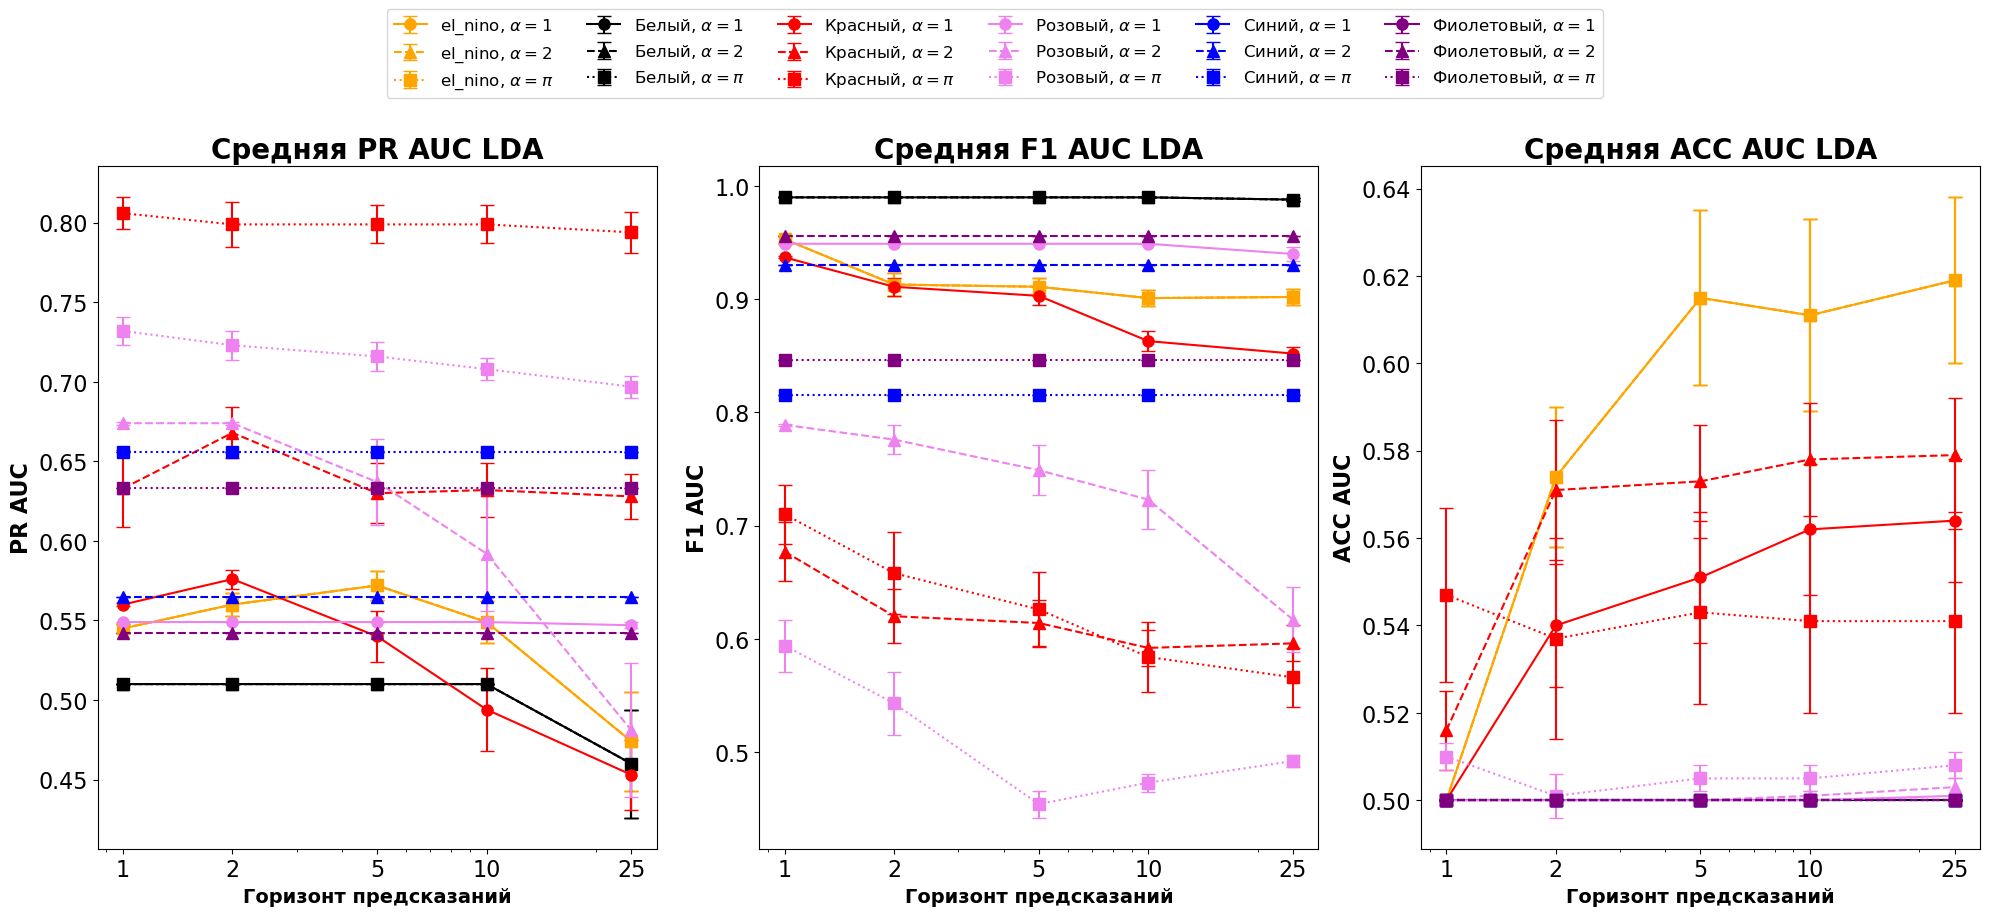

In [44]:
fig, ax = plt.subplots(ncols=3, figsize=(20, 8))

# PR
categories, horizons, values, errors = metric_data(lda_pr)
plot_metrics(ax[0], categories, horizons, values, errors, category_styles, 'PR AUC', 'Средняя PR AUC LDA')

# F1
categories_1, horizons_1, values_1, errors_1 = metric_data(lda_f1)
plot_metrics(ax[1], categories_1, horizons_1, values_1, errors_1, category_styles, 'F1 AUC', 'Средняя F1 AUC LDA')

# ACC
categories_2, horizons_2, values_2, errors_2 = metric_data(lda_acc)
plot_metrics(ax[2], categories_2, horizons_2, values_2, errors_2, category_styles, 'ACC AUC', 'Средняя ACC AUC LDA')

# легенда
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=6, fontsize=12)

plt.tight_layout()
plt.show()
fig.savefig('quality_metrics_LDA.jpeg', format='jpeg', dpi=200, bbox_inches='tight')

## QDA

In [56]:
qda_pr = pd.read_csv('QDA_pr.csv')
qda_f1 = pd.read_csv('QDA_f1.csv')
qda_acc = pd.read_csv('QDA_acc.csv')

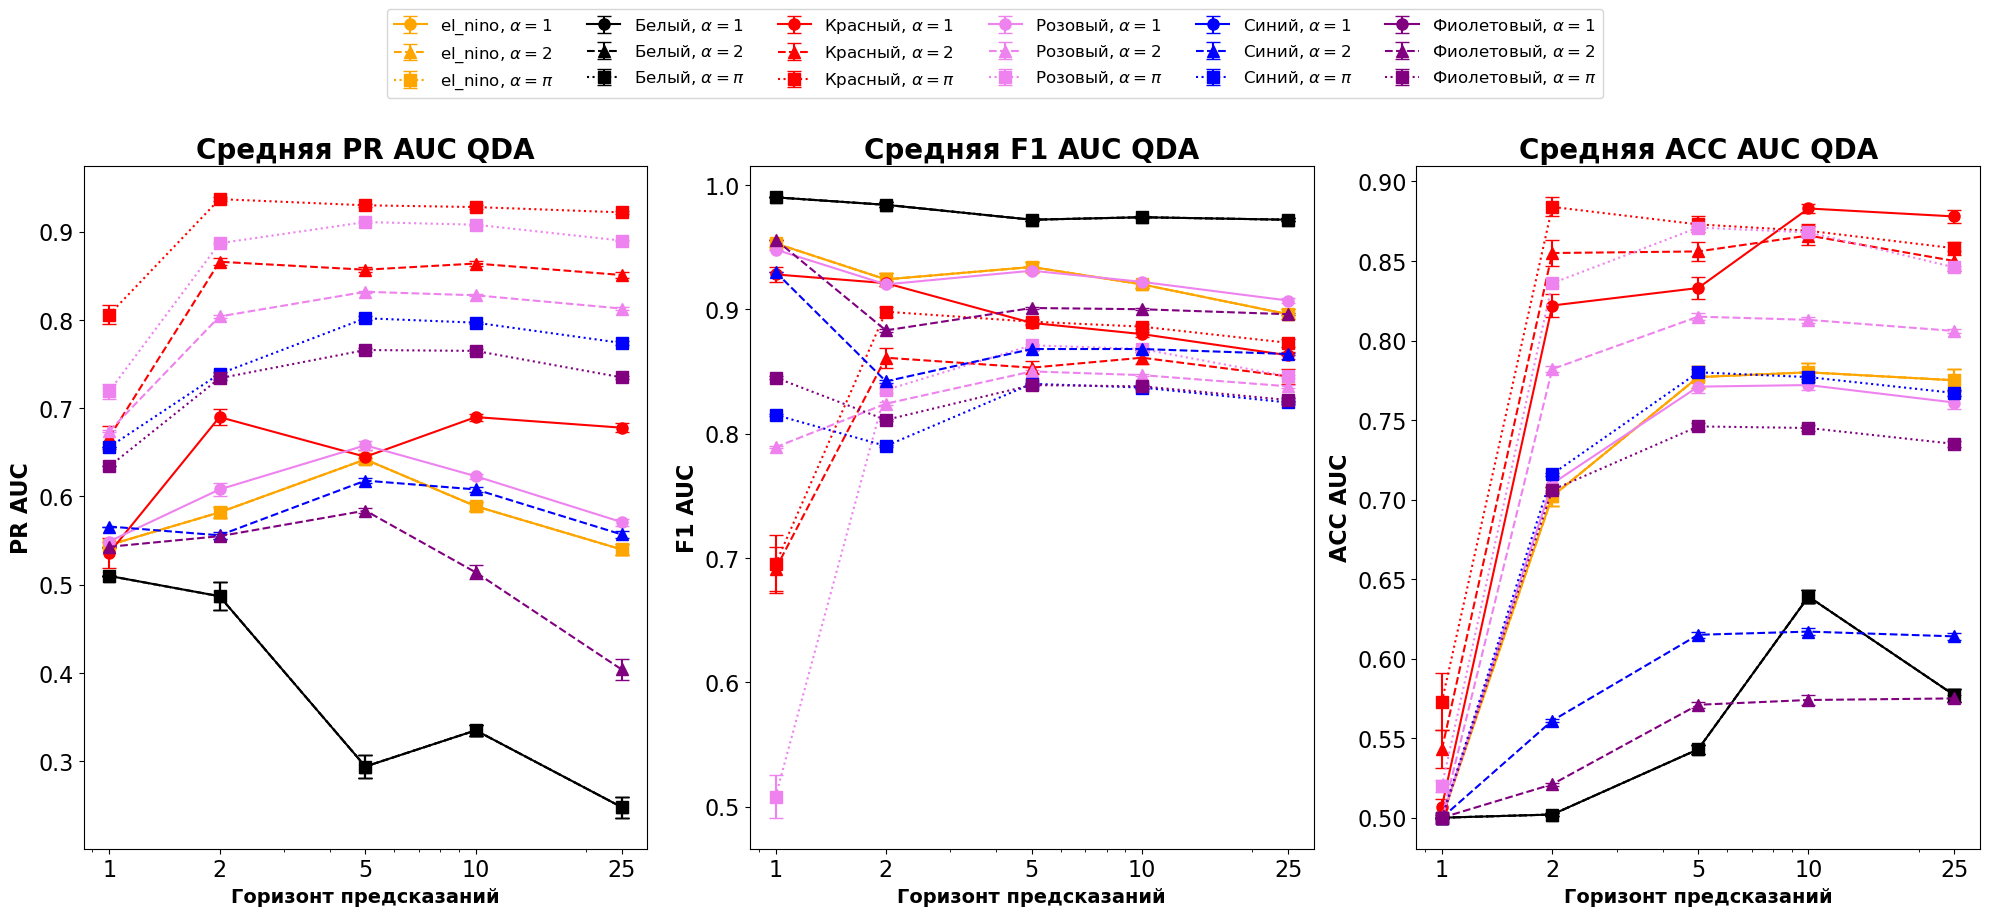

In [57]:
fig, ax = plt.subplots(ncols=3, figsize=(20, 8))

# PR
categories, horizons, values, errors = metric_data(qda_pr)
plot_metrics(ax[0], categories, horizons, values, errors, category_styles, 'PR AUC', 'Средняя PR AUC QDA')

# F1
categories_1, horizons_1, values_1, errors_1 = metric_data(qda_f1)
plot_metrics(ax[1], categories_1, horizons_1, values_1, errors_1, category_styles, 'F1 AUC', 'Средняя F1 AUC QDA')

# ACC
categories_2, horizons_2, values_2, errors_2 = metric_data(qda_acc)
plot_metrics(ax[2], categories_2, horizons_2, values_2, errors_2, category_styles, 'ACC AUC', 'Средняя ACC AUC QDA')

# легенда
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=6, fontsize=12)

plt.tight_layout()
plt.show()
fig.savefig('quality_metrics_LDA.jpeg', format='jpeg', dpi=200, bbox_inches='tight')

## Binseg

In [37]:
bns_pr = pd.read_csv('Binseg_pr.csv')
bns_f1 = pd.read_csv('Binseg_f1.csv')
bns_acc = pd.read_csv('Binseg_acc.csv')

In [41]:
fig, ax = plt.subplots(ncols=3, figsize=(20, 8))

# PR
categories_m0, horizons_m0, values_m0, errors_m0 = metric_data(bns_pr)
plot_metrics(ax[0], categories_m0, horizons_m0, values_m0, errors_m0, category_styles, 'PR AUC', 'Средняя PR AUC Binseg')

# F1
categories_m1, horizons_m1, values_m1, errors_m1 = metric_data(bns_f1)
plot_metrics(ax[1], categories_m1, horizons_m1, values_m1, errors_m1, category_styles, 'F1 AUC', 'Средняя F1 AUC Binseg')

# ACC
categories_m2, horizons_m2, values_m2, errors_m2 = metric_data(bns_acc)
plot_metrics(ax[2], categories_m2, horizons_m2, values_m2, errors_m2, category_styles, 'ACC AUC', 'Средняя ACC AUC Binseg')

# легенда
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=6, fontsize=12)

plt.tight_layout()
plt.show()
fig.savefig('quality_metrics_Cat.jpeg', format='jpeg', dpi=200, bbox_inches='tight')

## Window

In [17]:
wnd_pr = pd.read_csv('Window_pr.csv')
wnd_f1 = pd.read_csv('Window_f1.csv')
wnd_acc = pd.read_csv('Window_acc.csv')

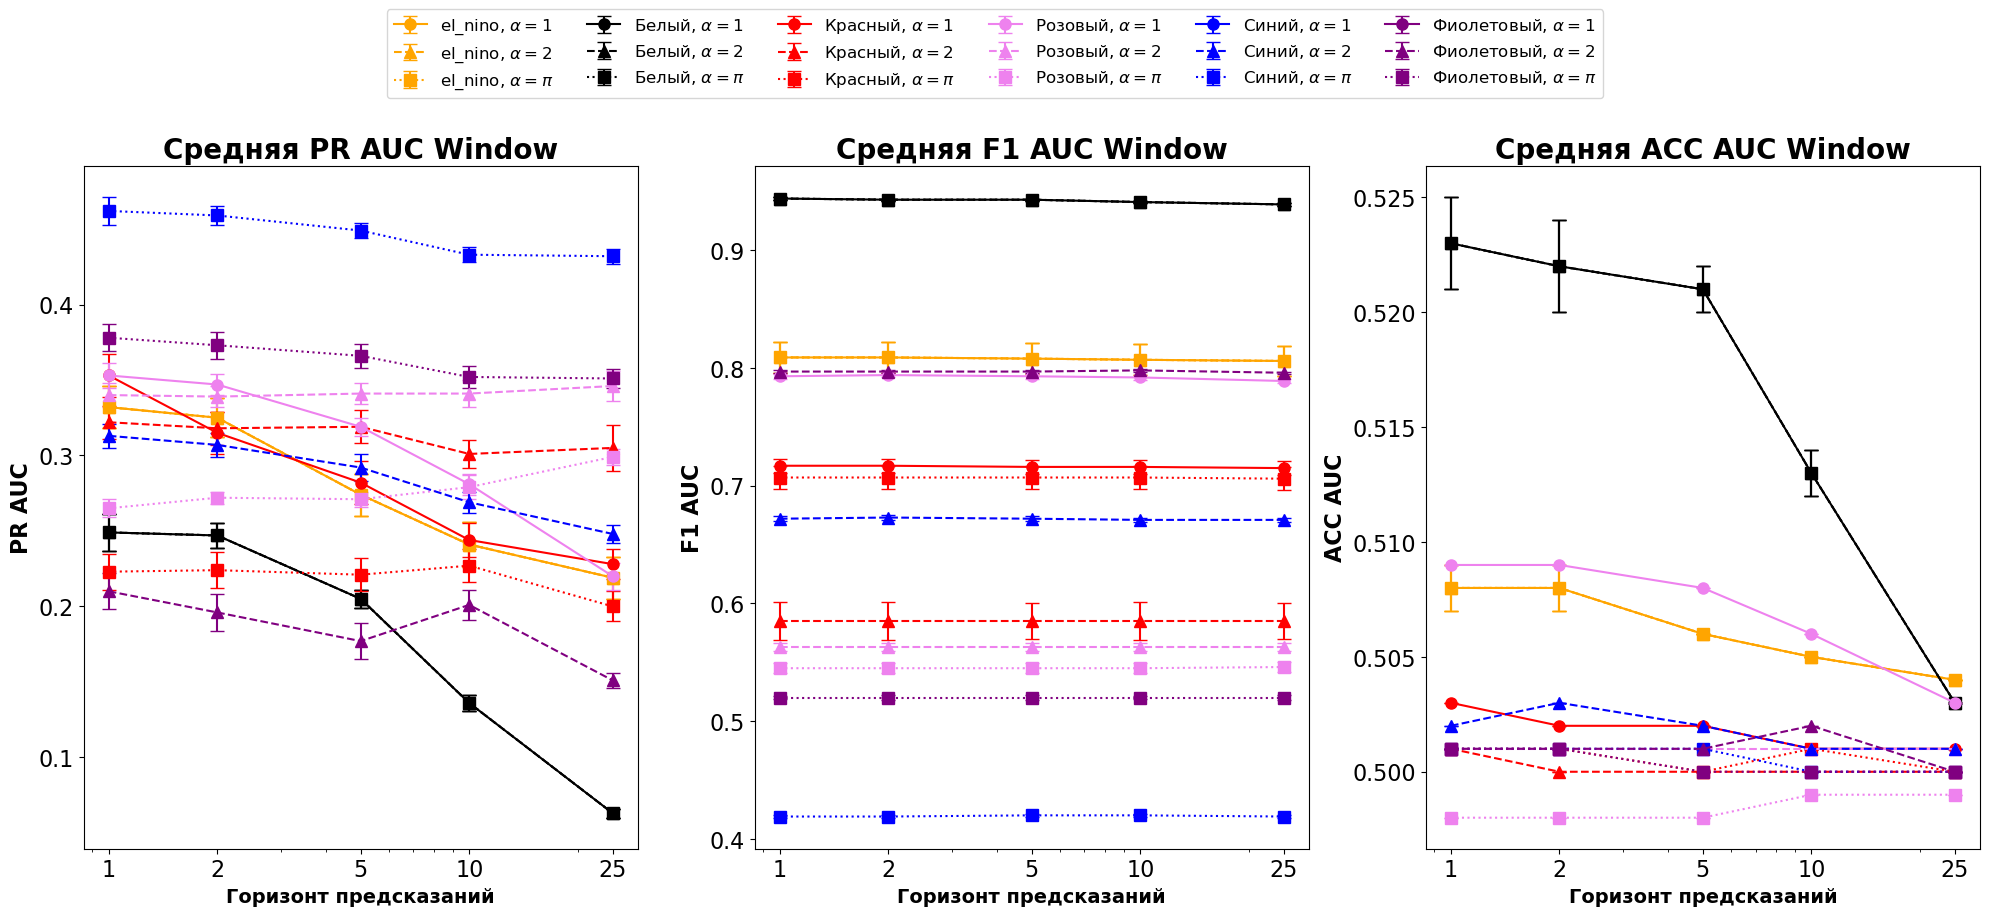

In [18]:
fig, ax = plt.subplots(ncols=3, figsize=(20, 8))

# PR
categories_m0, horizons_m0, values_m0, errors_m0 = metric_data(wnd_pr)
plot_metrics(ax[0], categories_m0, horizons_m0, values_m0, errors_m0, category_styles, 'PR AUC', 'Средняя PR AUC Window')

# F1
categories_m1, horizons_m1, values_m1, errors_m1 = metric_data(wnd_f1)
plot_metrics(ax[1], categories_m1, horizons_m1, values_m1, errors_m1, category_styles, 'F1 AUC', 'Средняя F1 AUC Window')

# ACC
categories_m2, horizons_m2, values_m2, errors_m2 = metric_data(wnd_acc)
plot_metrics(ax[2], categories_m2, horizons_m2, values_m2, errors_m2, category_styles, 'ACC AUC', 'Средняя ACC AUC Window')

# легенда
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=6, fontsize=12)

plt.tight_layout()
plt.show()
fig.savefig('quality_metrics_Cat.jpeg', format='jpeg', dpi=200, bbox_inches='tight')

## Pelt

In [45]:
plt_pr = pd.read_csv('Pelt_pr.csv')
plt_f1 = pd.read_csv('Pelt_f1.csv')
plt_acc = pd.read_csv('Pelt_acc.csv')

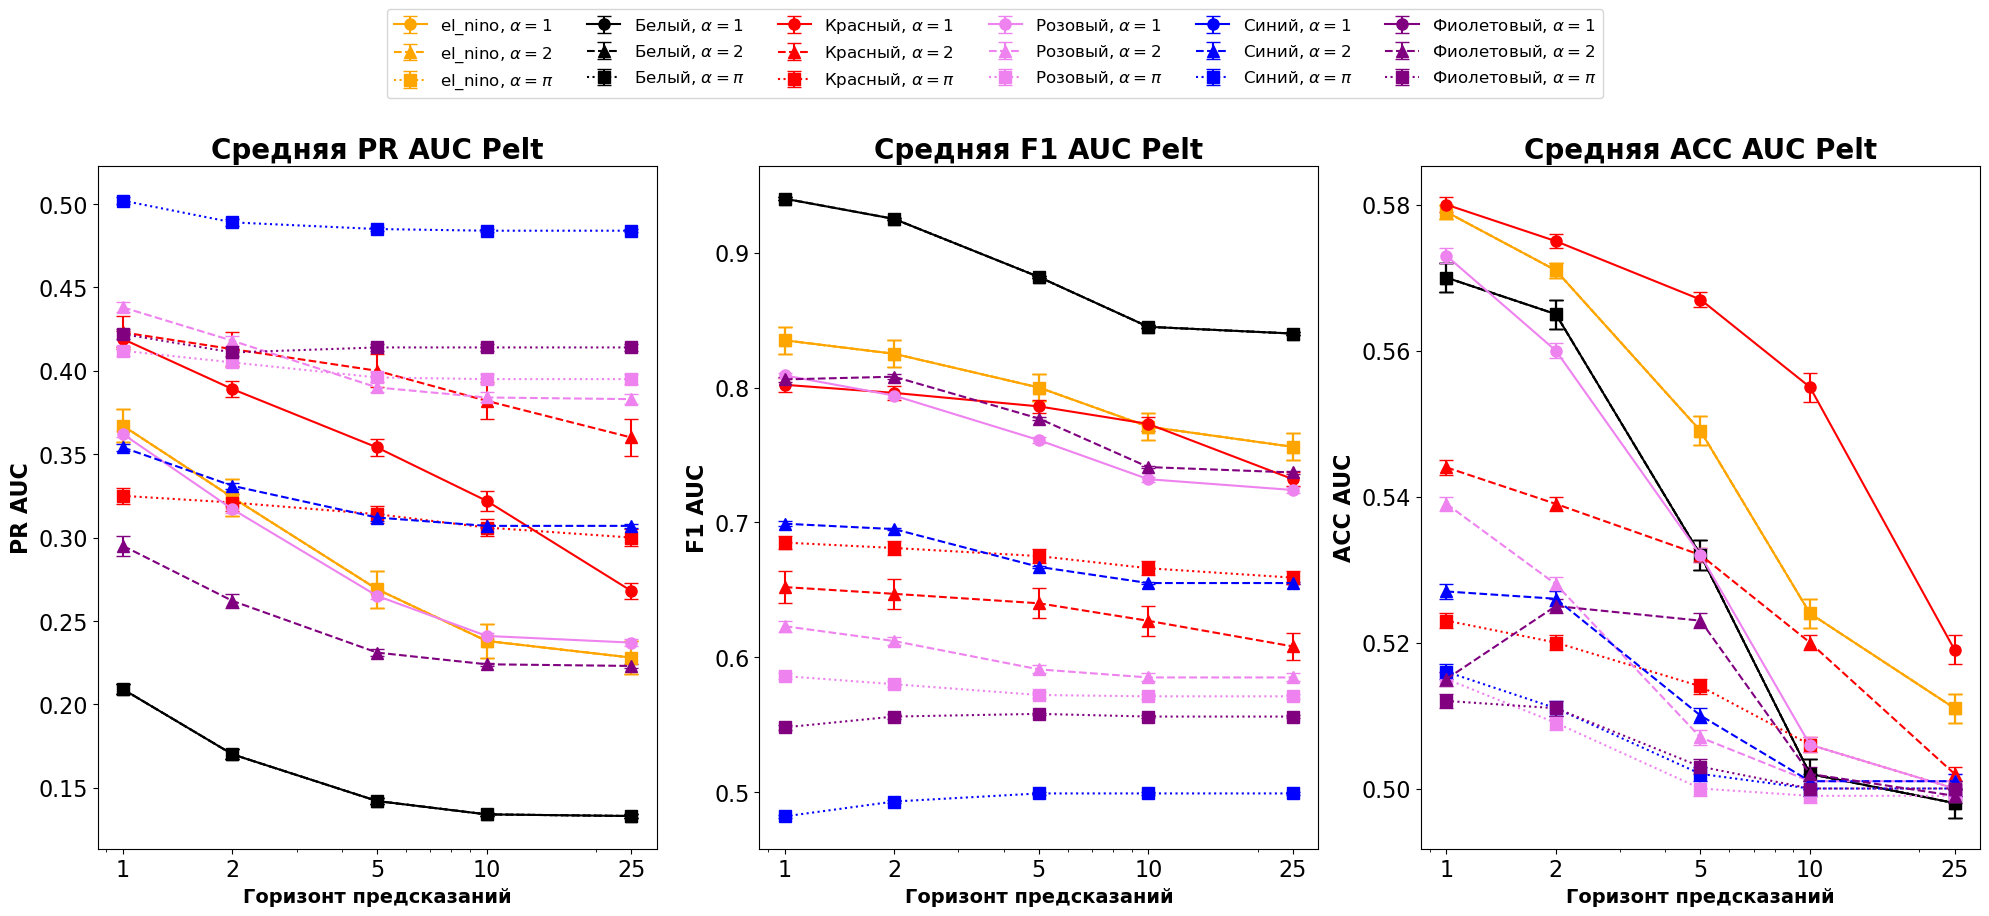

In [47]:
fig, ax = plt.subplots(ncols=3, figsize=(20, 8))

# PR
categories_m0, horizons_m0, values_m0, errors_m0 = metric_data(plt_pr)
plot_metrics(ax[0], categories_m0, horizons_m0, values_m0, errors_m0, category_styles, 'PR AUC', 'Средняя PR AUC Pelt')

# F1
categories_m1, horizons_m1, values_m1, errors_m1 = metric_data(plt_f1)
plot_metrics(ax[1], categories_m1, horizons_m1, values_m1, errors_m1, category_styles, 'F1 AUC', 'Средняя F1 AUC Pelt')

# ACC
categories_m2, horizons_m2, values_m2, errors_m2 = metric_data(plt_acc)
plot_metrics(ax[2], categories_m2, horizons_m2, values_m2, errors_m2, category_styles, 'ACC AUC', 'Средняя ACC AUC Pelt')

# легенда
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=6, fontsize=12)

plt.tight_layout()
plt.show()
fig.savefig('quality_metrics_Cat.jpeg', format='jpeg', dpi=200, bbox_inches='tight')

## MLP

In [11]:
mlp_pr = pd.read_csv('MLP_pr.csv')
mlp_f1 = pd.read_csv('MLP_f1.csv')
mlp_acc = pd.read_csv('MLP_acc.csv')

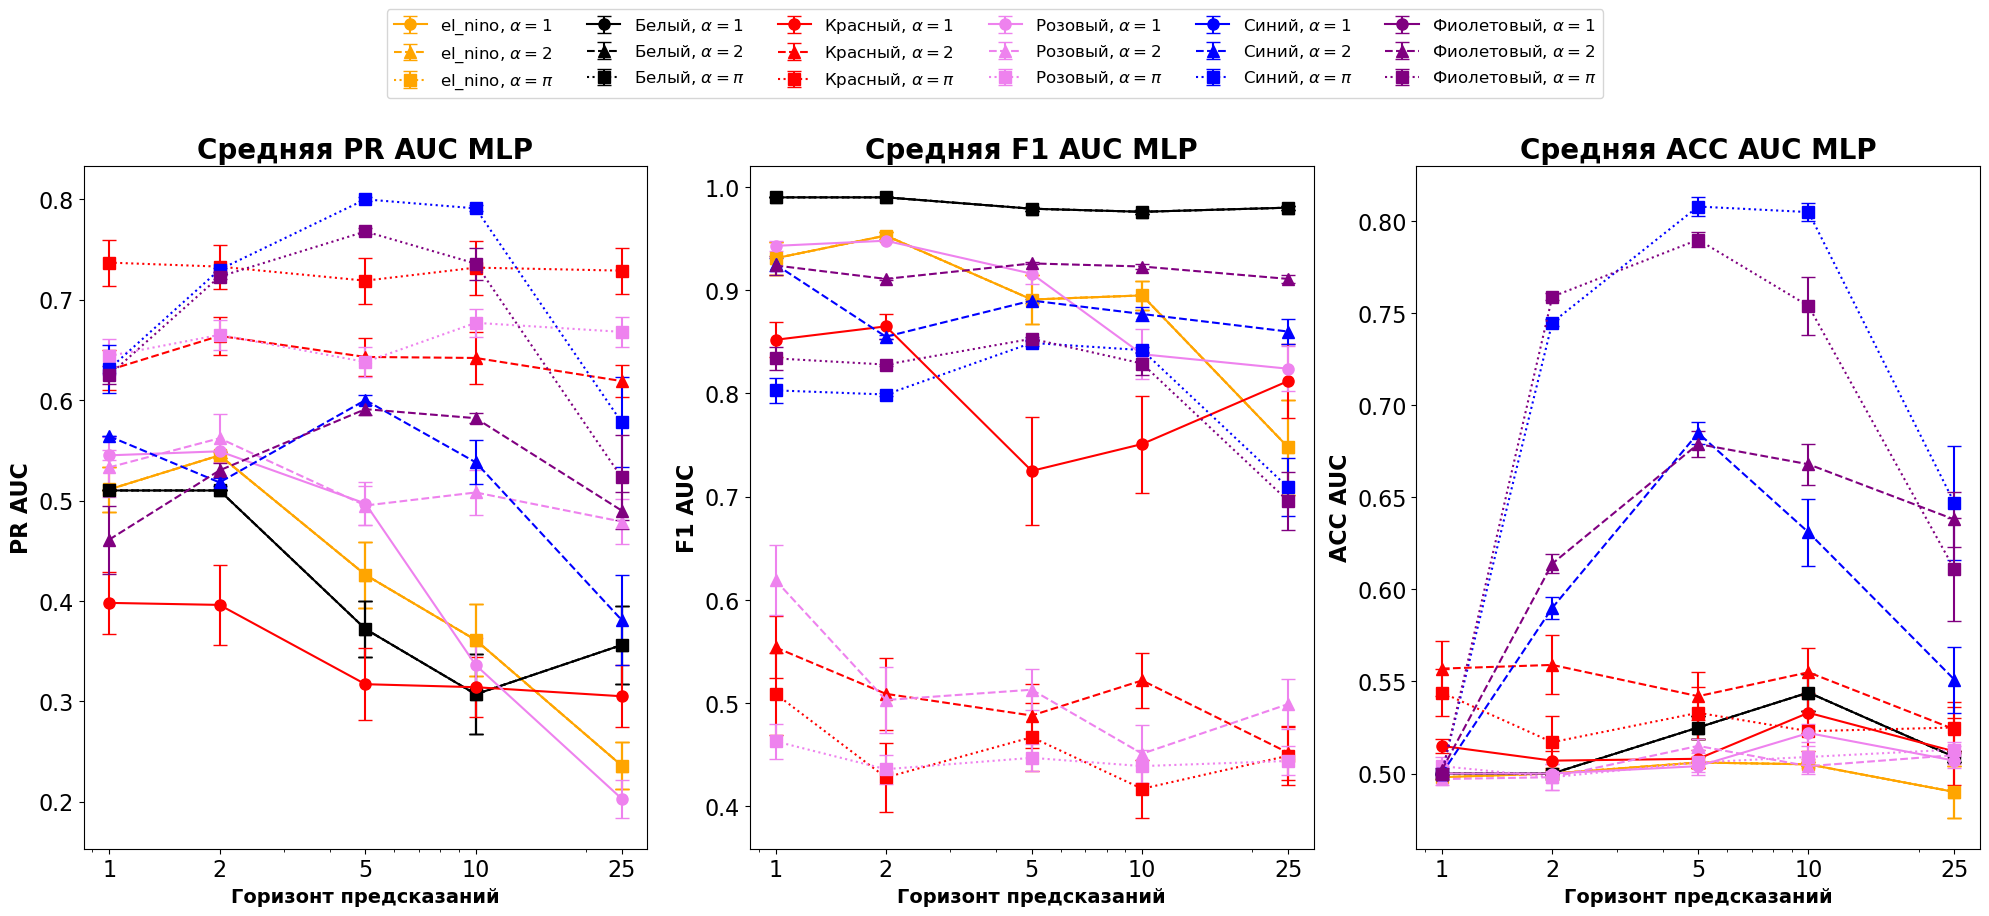

In [48]:
fig, ax = plt.subplots(ncols=3, figsize=(20, 8))

# PR
categories_m0, horizons_m0, values_m0, errors_m0 = metric_data(mlp_pr)
plot_metrics(ax[0], categories_m0, horizons_m0, values_m0, errors_m0, category_styles, 'PR AUC', 'Средняя PR AUC MLP')

# F1
categories_m1, horizons_m1, values_m1, errors_m1 = metric_data(mlp_f1)
plot_metrics(ax[1], categories_m1, horizons_m1, values_m1, errors_m1, category_styles, 'F1 AUC', 'Средняя F1 AUC MLP')

# ACC
categories_m2, horizons_m2, values_m2, errors_m2 = metric_data(mlp_acc)
plot_metrics(ax[2], categories_m2, horizons_m2, values_m2, errors_m2, category_styles, 'ACC AUC', 'Средняя ACC AUC MLP')

# легенда
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=6, fontsize=12)

plt.tight_layout()
plt.show()
fig.savefig('quality_metrics_MLP.jpeg', format='jpeg', dpi=200, bbox_inches='tight')

In [37]:
df_bns = results_to_csv(cpd_bns, "binseg_cpd_results.csv")
df_pelt = results_to_csv(cpd_plt, "pelt_cpd_results.csv")
df_wnd = results_to_csv(cpd_wnd, "window_cpd_results.csv")
df_lda = results_to_csv(cpd_lda, "lda_cpd_results.csv")
df_qda = results_to_csv(cpd_qda, "qda_cpd_results.csv")
df_mlp = results_to_csv(cpd_mlp, "mlp_cpd_results.csv")

df_all = pd.concat([df_bns, df_pelt, df_wnd, df_lda, df_qda, df_mlp], ignore_index=True)
df_all.to_csv("all_models_cpd_results_synth.csv", index=False)

Сохранено: pr_by_ticker_model_Binseg_synth.png


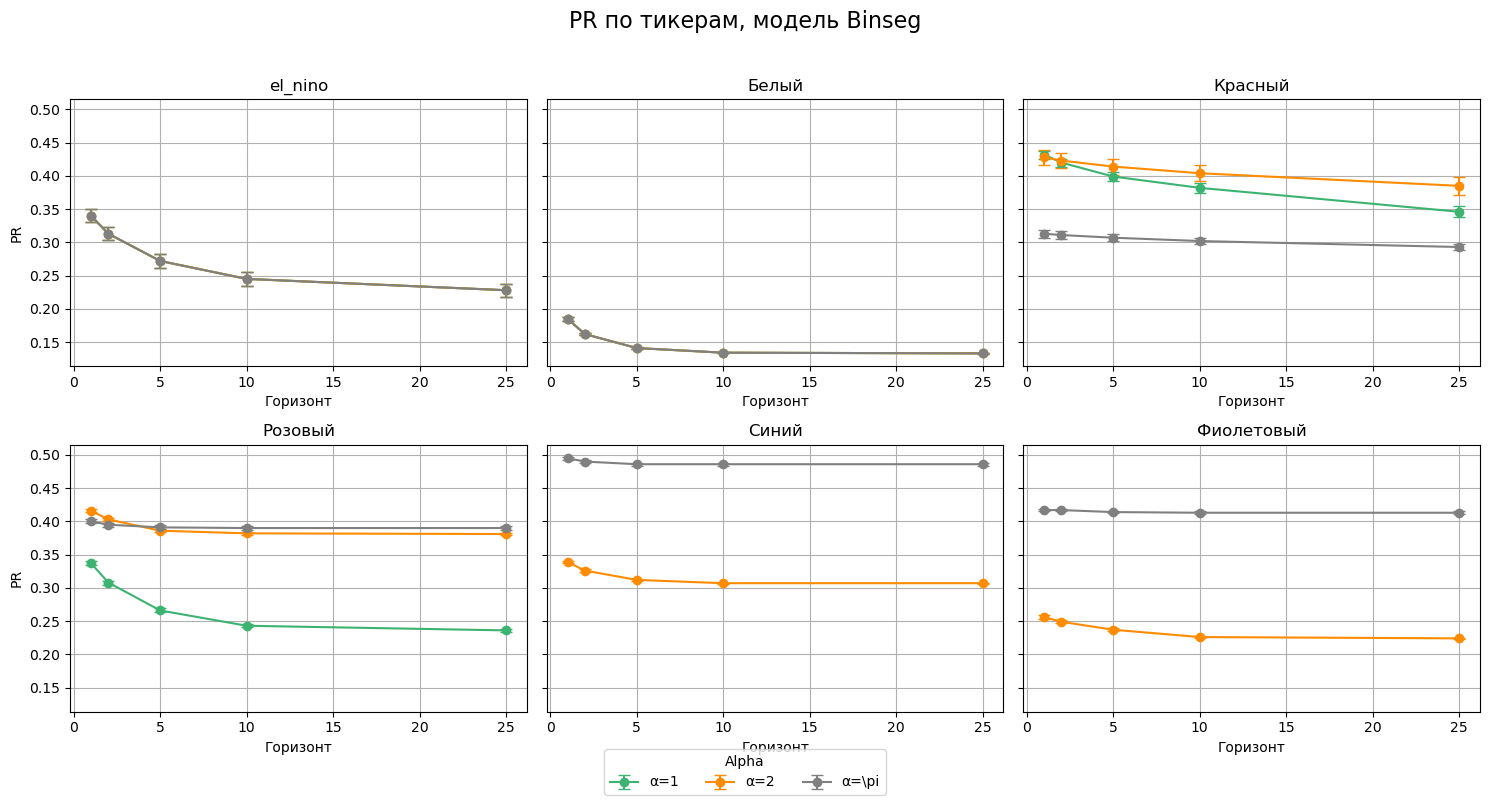

Сохранено: pr_by_ticker_model_LDA_synth.png


Сохранено: pr_by_ticker_model_MLP_synth.png


Сохранено: pr_by_ticker_model_Pelt_synth.png


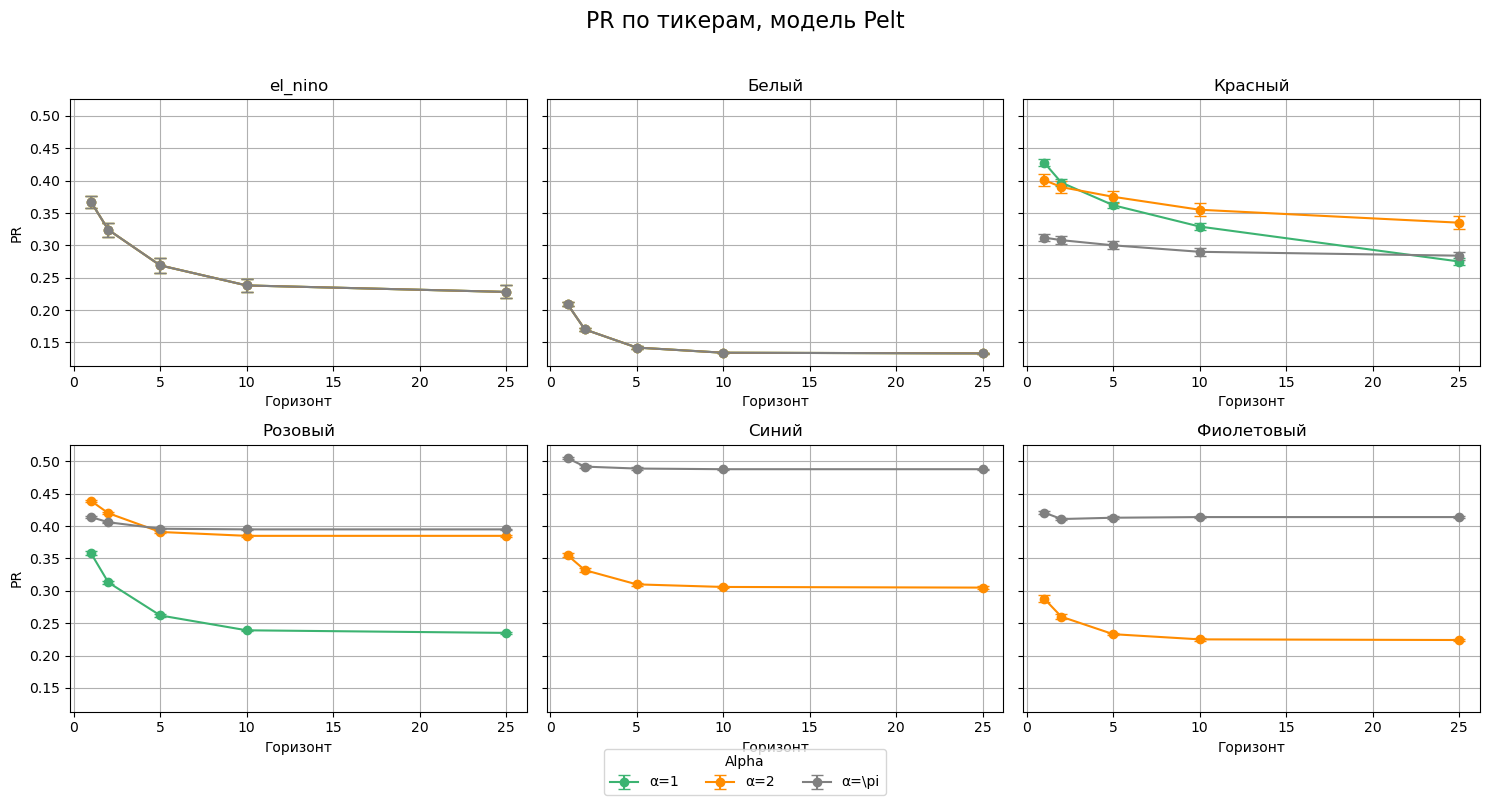

Сохранено: pr_by_ticker_model_QDA_synth.png


Сохранено: pr_by_ticker_model_Window_synth.png


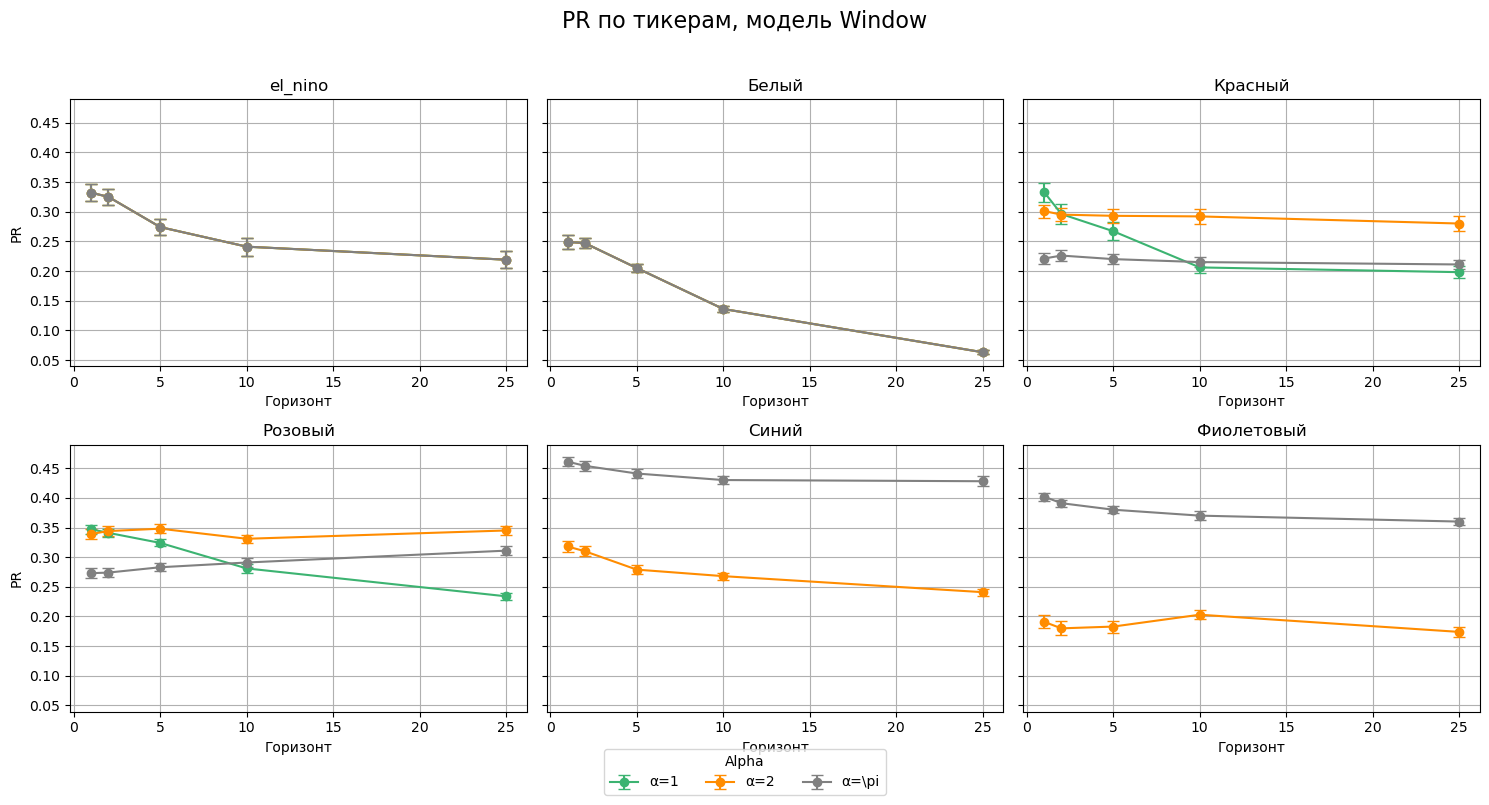

In [39]:
# df = pd.read_csv("all_models_cpd_results_synth.csv")

# def parse_metric(val):
#     try:
#         mean, std = val.split(' ± ')
#         return float(mean), float(std)
#     except:
#         return None, None

# df[['mean', 'stderr']] = df['metric_value'].apply(lambda x: pd.Series(parse_metric(x)))

# def plot_grid(df, target_metric="pr"):
#     df = df[df['metric_name'] == target_metric]
#     tickers = sorted(df['noise_type'].unique())
#     models = sorted(df['model'].unique())
#     alphas = sorted(df['alpha'].unique())

#     color_map = {
#         "1": "mediumseagreen",
#         "2": "darkorange",
#         "3": "crimson"
#     }

#     n_cols = 3
#     n_rows = int(np.ceil(len(tickers) / n_cols))

#     for model in models:
#         df_model = df[df['model'] == model]

#         fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), sharey=True)
#         axes = axes.flatten()

#         for i, ticker in enumerate(tickers):
#             ax = axes[i]
#             df_ticker = df_model[df_model['noise_type'] == ticker]

#             for alpha in alphas:
#                 alpha_str = str(alpha)
#                 df_alpha = df_ticker[df_ticker['alpha'] == alpha]
#                 if not df_alpha.empty:
#                     ax.errorbar(df_alpha['horizon'], df_alpha['mean'], yerr=df_alpha['stderr'],
#                                 fmt='-o', label=f"α={alpha}",
#                                 color=color_map.get(alpha_str, 'gray'),
#                                 capsize=4)

#             ax.set_title(ticker)
#             ax.set_xlabel("Горизонт")
#             if i % n_cols == 0:
#                 ax.set_ylabel(target_metric.upper())
#             ax.grid(True)

#         for j in range(len(tickers), len(axes)):
#             fig.delaxes(axes[j])

#         fig.suptitle(f"{target_metric.upper()} по тикерам, модель {model}", fontsize=16)
#         handles, labels = ax.get_legend_handles_labels()
#         fig.legend(handles, labels, title="Alpha", loc='lower center', ncol=len(alphas), bbox_to_anchor=(0.5, -0.01))
#         plt.tight_layout(rect=[0, 0.03, 1, 0.96])
        
#         filename = f"{target_metric}_by_ticker_model_{model}_synth.png"
#         plt.savefig(filename, dpi=300, bbox_inches='tight')
#         print(f"Сохранено: {filename}")
#         plt.show()

# plot_grid(df, target_metric="pr")

Сохранено: pr_Binseg_synth.png


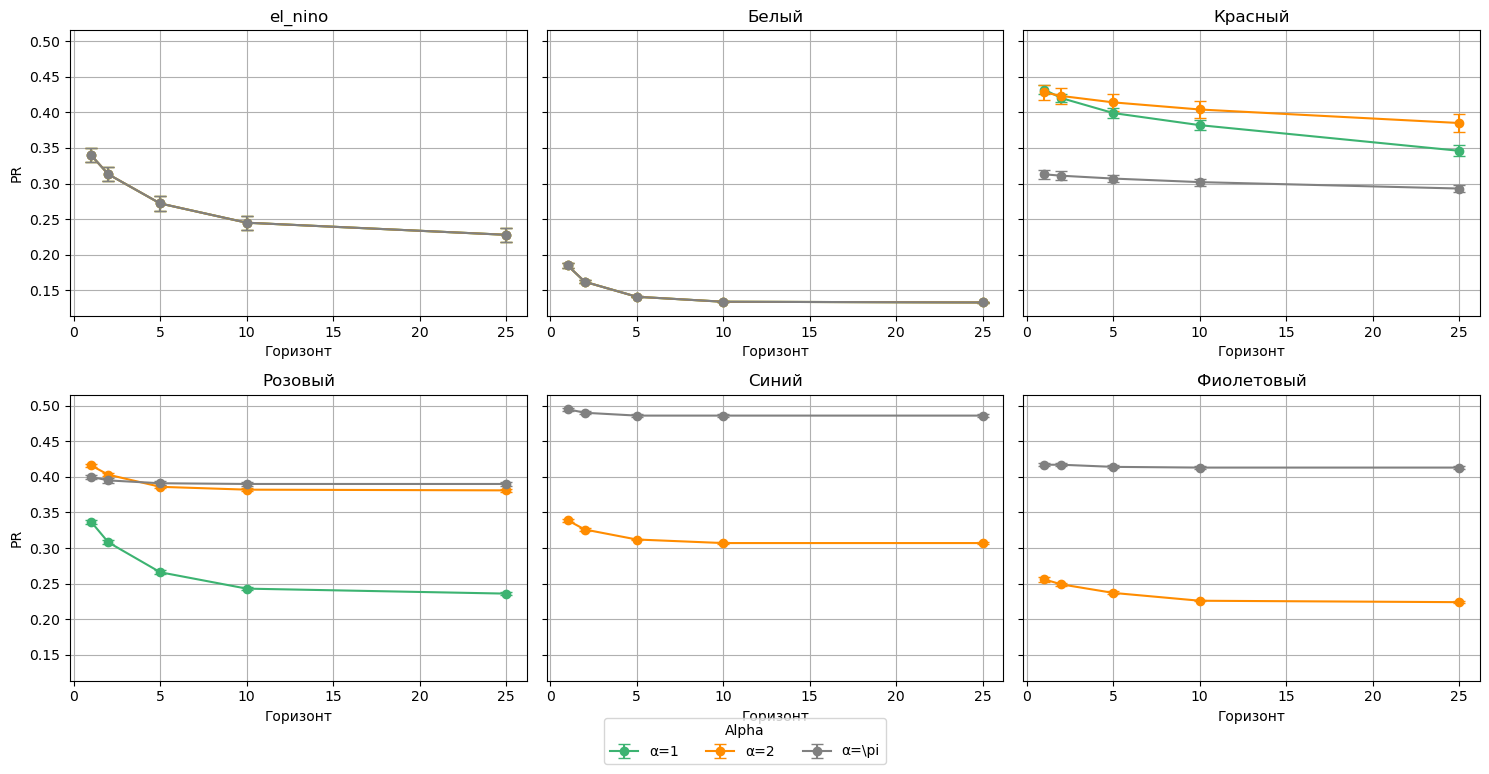

Сохранено: pr_LDA_synth.png


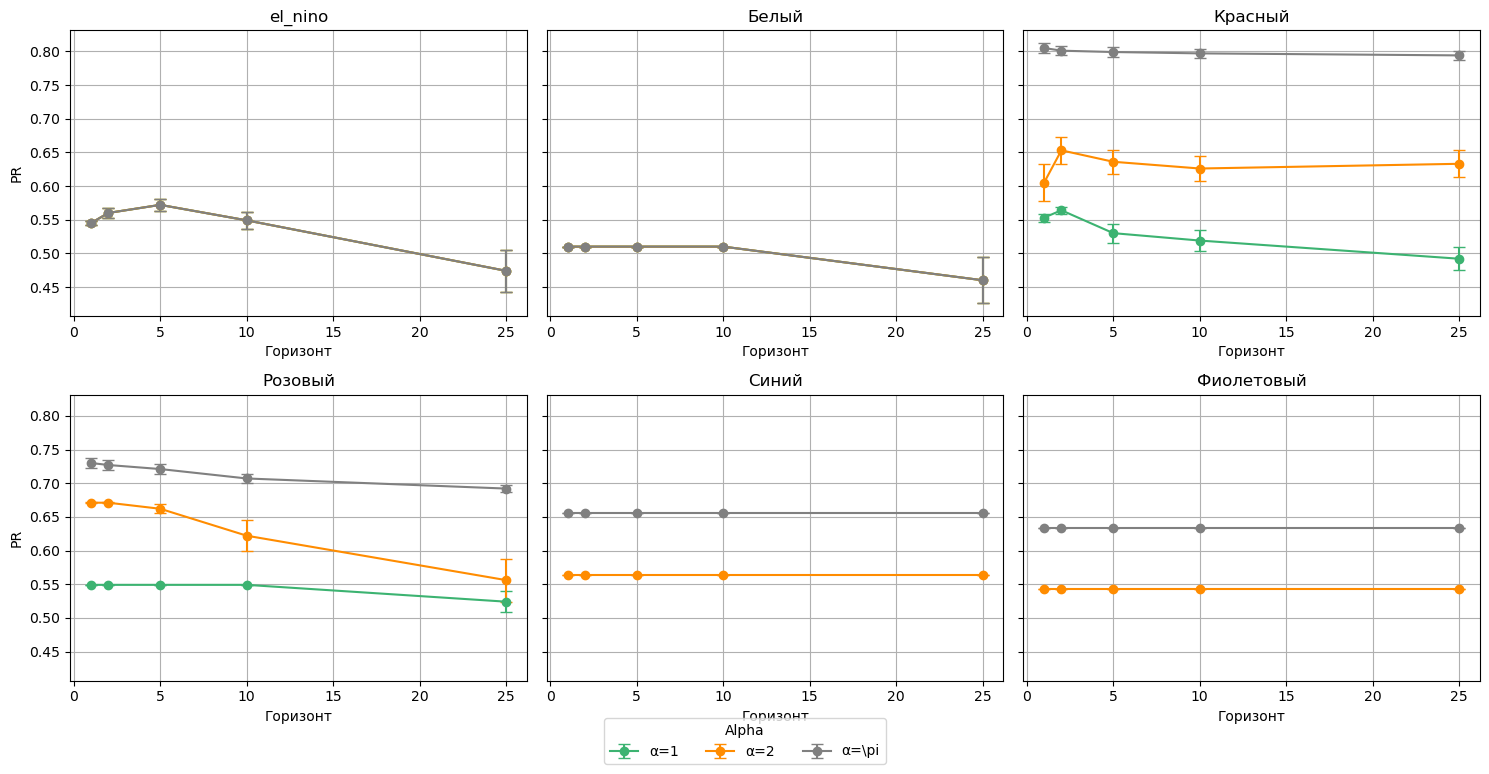

Сохранено: pr_MLP_synth.png


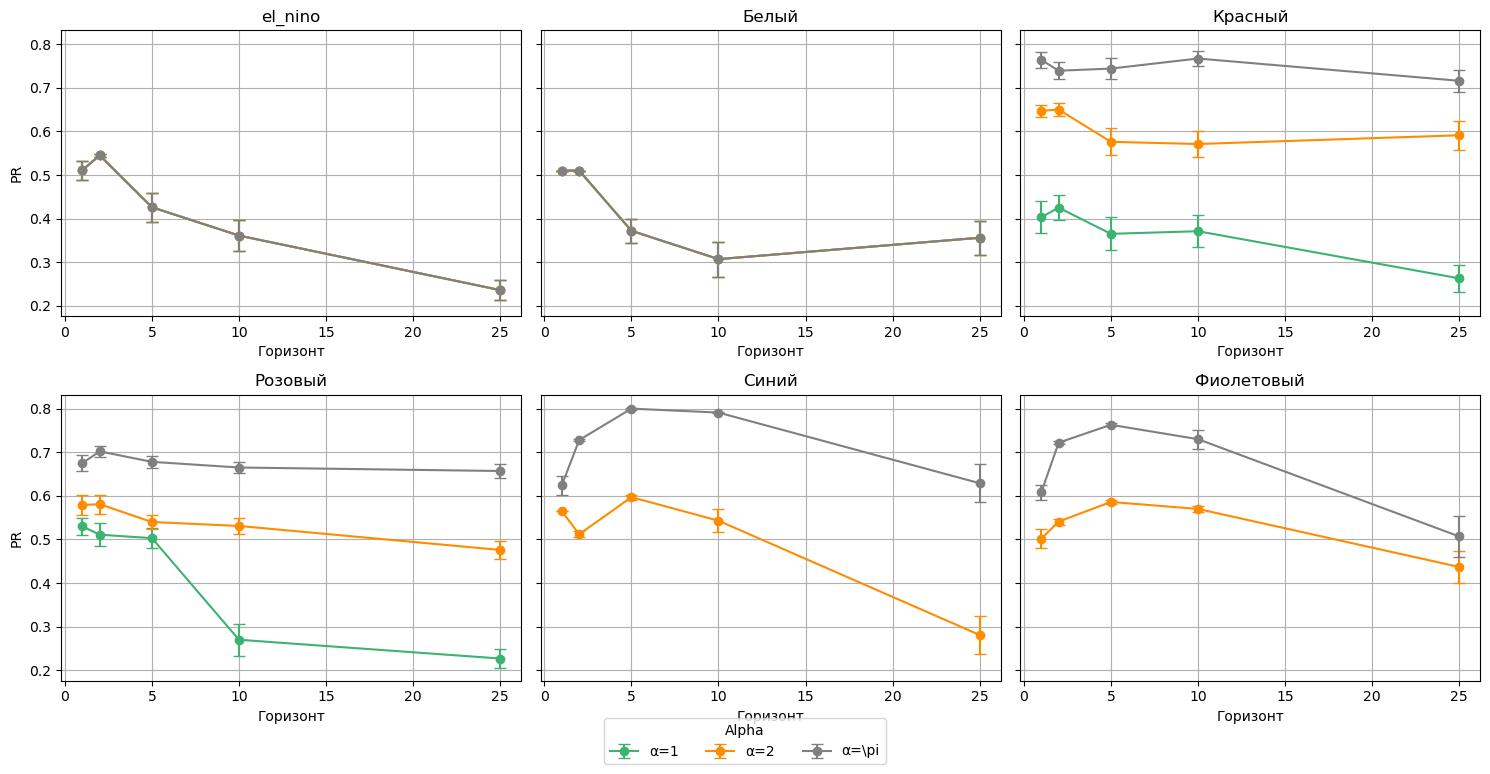

Сохранено: pr_Pelt_synth.png


Сохранено: pr_QDA_synth.png


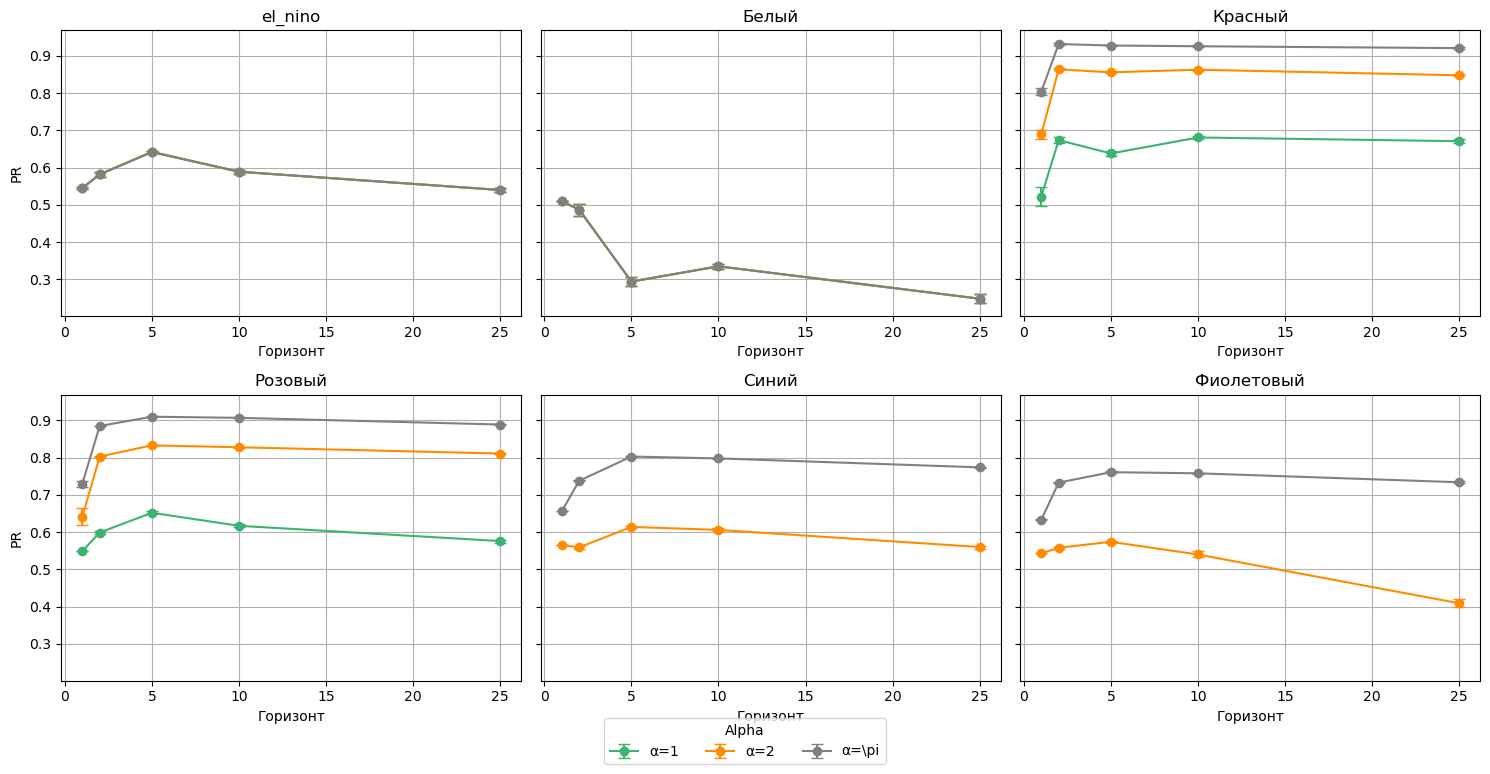

Сохранено: pr_Window_synth.png


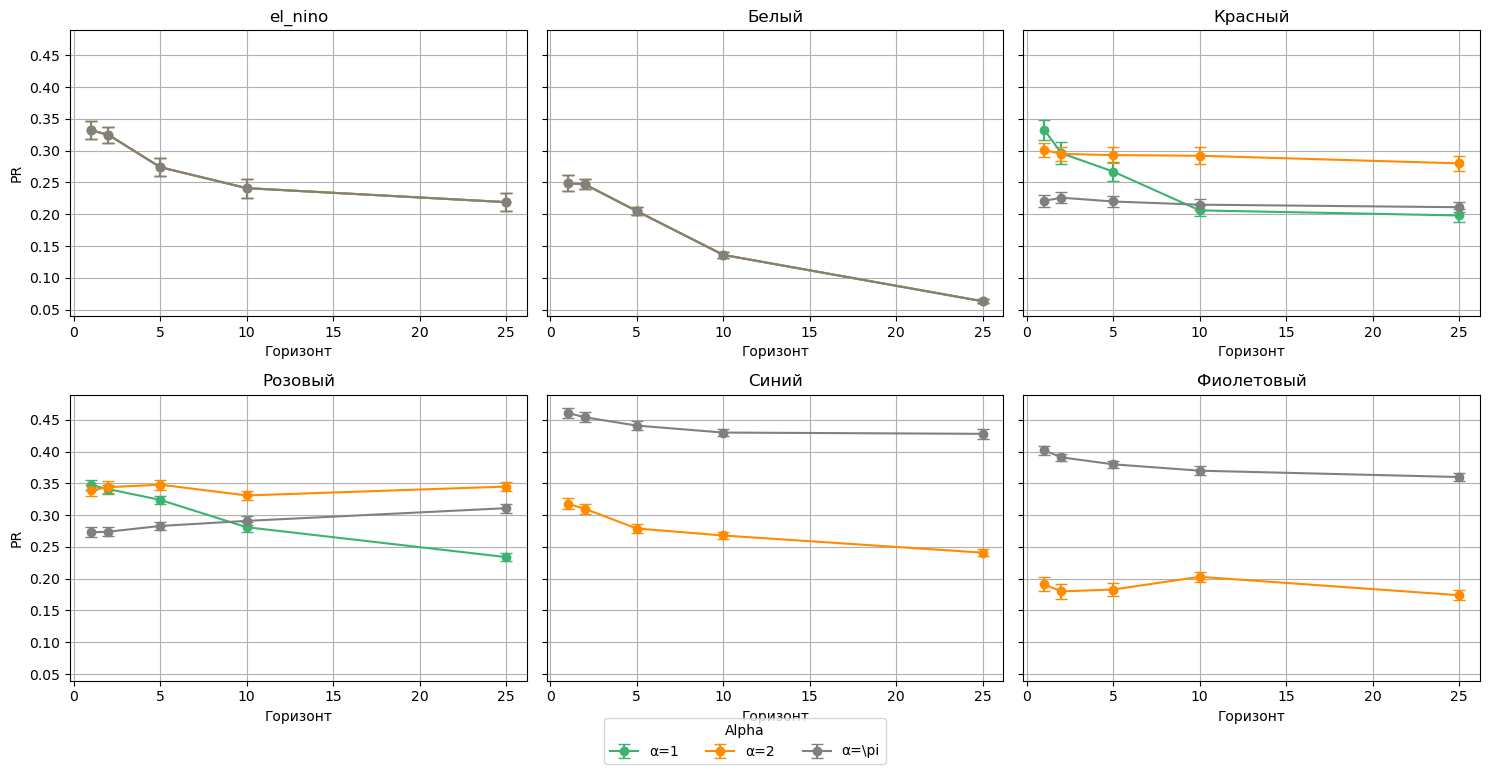

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("all_models_cpd_results_synth.csv")

def parse_metric(val):
    try:
        mean, std = val.split(' ± ')
        return float(mean), float(std)
    except:
        return None, None

df[['mean', 'stderr']] = df['metric_value'].apply(lambda x: pd.Series(parse_metric(x)))

def plot_grid(df, target_metric="pr"):
    df = df[df['metric_name'] == target_metric]
    tickers = sorted(df['noise_type'].unique())
    models = sorted(df['model'].unique())
    alphas = sorted(df['alpha'].unique())

    color_map = {
        "1": "mediumseagreen",
        "2": "darkorange",
        "3": "crimson"
    }

    n_cols = 3
    n_rows = int(np.ceil(len(tickers) / n_cols))

    for model in models:
        df_model = df[df['model'] == model]

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), sharey=True)
        axes = axes.flatten()

        for i, ticker in enumerate(tickers):
            ax = axes[i]
            df_ticker = df_model[df_model['noise_type'] == ticker]

            for alpha in alphas:
                alpha_str = str(alpha)
                df_alpha = df_ticker[df_ticker['alpha'] == alpha]
                if not df_alpha.empty:
                    ax.errorbar(df_alpha['horizon'], df_alpha['mean'], yerr=df_alpha['stderr'],
                                fmt='-o', label=f"α={alpha}",
                                color=color_map.get(alpha_str, 'gray'),
                                capsize=4)

            ax.set_title(ticker)
            ax.set_xlabel("Горизонт")
            if i % n_cols == 0:
                ax.set_ylabel(target_metric.upper())
            ax.grid(True)

        for j in range(len(tickers), len(axes)):
            fig.delaxes(axes[j])

        #fig.suptitle(f"{target_metric.upper()} по тикерам, модель {model}", fontsize=16)
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels, title="Alpha", loc='lower center', ncol=len(alphas), bbox_to_anchor=(0.5, -0.01))
        plt.tight_layout(rect=[0, 0.03, 1, 0.96])
        
        filename = f"{target_metric}_{model}_synth.png"
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"Сохранено: {filename}")
        plt.show()

plot_grid(df, target_metric="pr")